In [1]:
#Base libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from copy import deepcopy
import inspect
import fnmatch

from scipy.interpolate import NearestNDInterpolator
from scipy.interpolate import RegularGridInterpolator
from numpy.ma import masked_array
from scipy.interpolate import CubicSpline
from scipy import signal

from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

from contourpy import contour_generator
from matplotlib.colors import BoundaryNorm

#Configuring relative file locations
homeDir = os.path.abspath("")
srcDir = os.path.join(homeDir,"src")
plotDir = os.path.join(homeDir,"plots")
dataDir = os.path.join(homeDir,"data")

In [2]:
#Miscellenaeous functions

def low_pass_filt(sig, sampleFreq, cutOffFreq):
    
    Wn = cutOffFreq/(0.5 * sampleFreq)
    b, a = signal.butter(2, Wn)
    
    return signal.filtfilt(b, a, sig)

In [3]:
#piv data structure definition

class planar_piv_data:
    """A class representing planar PIV data.
    Attributes:
    - deflt_grid_x: numpy.ndarray
        The default grid x-coordinates.
    - deflt_grid_z: numpy.ndarray
        The default grid z-coordinates.
    - grid_x: numpy.ndarray
        The grid x-coordinates.
    - grid_z: numpy.ndarray
        The grid z-coordinates.
    - deflt_grid_v_x: numpy.ndarray
        The default grid x-velocity.
    - grid_v_x: numpy.ndarray
        The grid x-velocity.
    - grid_v_z: numpy.ndarray
        The grid z-velocity.
    - grid_v_mag: numpy.ndarray
        The grid velocity magnitude.
    - grid_omega_y: numpy.ndarray
        The grid y-vorticity.
    - grid_omega_mag: numpy.ndarray
        The grid vorticity magnitude.
    - grid_r_xx: numpy.ndarray
        The grid xx Reynolds stress.
    - grid_r_xz: numpy.ndarray
        The grid xz Reynolds stress.
    - grid_r_zz: numpy.ndarray
        The grid zz Reynolds stress.
    - grid_std_v_x: numpy.ndarray
        The grid x-velocity standard deviation.
    - grid_std_v_z: numpy.ndarray
        The grid z-velocity standard deviation.
    - grid_valid_cell: numpy.ndarray
        The grid valid cell mask.
    Methods:
    - __init__(frame_i, frame_j, frame_data)
        Initializes the planar_piv_data object.
    - corr_frame(x_corr, z_corr, mode="absolute")
        Adjusts the grid_x and grid_z coordinates based on the given correction values.
    - reorient_frame(disc_xc, disc_zc)
        Reorients the frame of the grid by subtracting the given disc_xc and disc_zc values.
    - gen_data_intpr()
        Generates interpolated data for the object.
    """
      
    
    def __init__(self, frame_i, frame_j, frame_data):
        """
        Initializes the grid and velocity data for the given frames.
        Parameters:
        frame_i (int): Number of rows in the grid.
        frame_j (int): Number of columns in the grid.
        frame_data (numpy.ndarray): Array containing the grid and velocity data. 
            The array is expected to have the following columns:
            - Column 0: x-coordinates of the grid points.
            - Column 1: z-coordinates of the grid points.
            - Column 2: x-components of the velocity at the grid points.
            - Column 3: z-components of the velocity at the grid points.
            - Column 4: Magnitude of the velocity at the grid points.
            - Column 5: y-components of the vorticity at the grid points.
            - Column 6: Magnitude of the vorticity at the grid points.
            - Column 7: xx-components of the Reynolds stress at the grid points.
            - Column 8: xz-components of the Reynolds stress at the grid points.
            - Column 9: zz-components of the Reynolds stress at the grid points.
            - Column 10: Standard deviation of the x-components of the velocity.
            - Column 11: Standard deviation of the z-components of the velocity.
            - Column 12: Validity of the grid cells (boolean).
        """
        
        self.deflt_grid_x = frame_data[:,0].reshape(frame_i, frame_j, order='F')
        self.deflt_grid_z = frame_data[:,1].reshape(frame_i, frame_j, order='F')
        self.grid_x  = deepcopy(self.deflt_grid_x)
        self.grid_z = deepcopy(self.deflt_grid_z)
        self.deflt_grid_v_x = frame_data[:,2].reshape(frame_i, frame_j, order='F')
        self.grid_v_x = deepcopy(self.deflt_grid_v_x)
        self.grid_v_z = frame_data[:,3].reshape(frame_i, frame_j, order='F')
        self.grid_v_mag = frame_data[:,4].reshape(frame_i, frame_j, order='F')
        self.grid_omega_y = frame_data[:,5].reshape(frame_i, frame_j, order='F')
        self.grid_omega_mag = frame_data[:,6].reshape(frame_i, frame_j, order='F')
        self.grid_r_xx = frame_data[:,7].reshape(frame_i, frame_j, order='F')
        self.grid_r_xz = frame_data[:,8].reshape(frame_i, frame_j, order='F')
        self.grid_r_zz = frame_data[:,9].reshape(frame_i, frame_j, order='F')
        self.grid_std_v_x = frame_data[:,10].reshape(frame_i, frame_j, order='F')
        self.grid_std_v_z = frame_data[:,11].reshape(frame_i, frame_j, order='F')
        self.grid_valid_cell = frame_data[:,12].reshape(frame_i, frame_j, order='F').astype(bool)
        
    def corr_frame(self, x_corr, z_corr, mode = "absolute"):
        """
        Adjusts the grid_x and grid_z coordinates based on the given x_corr and z_corr values.
        Parameters:
        - x_corr: float or int
            The correction value to be added to the grid_x coordinates.
        - z_corr: float or int
            The correction value to be added to the grid_z coordinates.
        - mode: str, optional (default: "absolute")
            The mode of correction. It can be either "absolute" or "relative".
            - "absolute": Adds the correction values directly to the resetted grid_x and grid_z coordinates.
            - "relative": Adds the correction values to the existing grid_x and grid_z coordinates.
        Returns:
        None
        """
            
        if mode == "absolute":
            
            self.grid_x = deepcopy(self.deflt_grid_x)
            self.grid_z = deepcopy(self.deflt_grid_z)
            
            self.grid_x += x_corr
            self.grid_z += z_corr
            
        elif mode == "relative":
            
            self.grid_x += x_corr
            self.grid_z += z_corr
        
    def reorient_frame(self, disc_xc, disc_zc):
        """
        Reorients the frame of the grid by subtracting the given disc_xc and disc_zc values from the grid coordinates.
        Then, it multiplies the grid_x and grid_v_x values by -1, and divides the grid_x and grid_z values by 200.
        Parameters:
        - disc_xc: The x-coordinate of the disc
        - disc_zc: The z-coordinate of the disc
        """
        
        self.grid_x = deepcopy(self.deflt_grid_x)
        self.grid_z = deepcopy(self.deflt_grid_z)
        self.grid_v_x = deepcopy(self.deflt_grid_v_x)
               
        self.grid_x -= disc_xc
        self.grid_z -= disc_zc
        
        self.grid_x *= -1
        self.grid_v_x *= -1
        self.grid_x /= 200
        self.grid_z /= 200
        
    def gen_data_intpr(self):
        """
        Generate interpolated data for the given object.
        This method checks if the interpolated data already exists for the object. If it does, the interpolation is skipped.
        Otherwise, it interpolates the dependent data using the NearestNDInterpolator.
        Parameters:
        - self: The object instance.
        Returns:
        - None
        """
                
        for name, value in inspect.getmembers(self):
            
            if fnmatch.fnmatch(name, "grid*intpr"): 
                return
        
        for name, value in inspect.getmembers(self):
            
            if fnmatch.fnmatch(name, "grid*") and name != "grid_x" and name != "grid_z" and name != "grid_valid_cell":
            
                setattr(self, name + "_intpr", NearestNDInterpolator((self.grid_x[self.grid_valid_cell], self.grid_z[self.grid_valid_cell]), getattr(self, name)[self.grid_valid_cell]))
        
class stitched_planar_piv_data:
    '''A class representing stitched planar PIV data.
    Methods:
    - __init__(): Initializes the stitched_planar_piv_data object.
    - stitch_frames(frame0, frame1, frame_res, exp_factor): Stitches two frames of PIV data together.
    - gen_data_intpr(): Generates interpolated data for the object.
        Stitches two frames of PIV data together.
        - frame0: The first frame of PIV data.
        - frame1: The second frame of PIV data.
        - frame_res: The resolution of the frames.
        - exp_factor: The exponential factor for calculating the weights.
        Generates interpolated data for the given object.'''
    
    def __init__(self):
        
        pass
    
    def stitch_frames(self, frame0, frame1, frame_res, exp_factor = 12):
        """
        Stitch two frames together using overlapping weights.
        Parameters:
        - frame0 (Frame): The first frame to be stitched.
        - frame1 (Frame): The second frame to be stitched.
        - frame_res (float): The resolution of the resulting frame.
        - exp_factor (int, optional): The exponential factor used in the weight calculation. Defaults to 12.
        Returns:
        None
        """
        
        for name, value in inspect.getmembers(self): #Check if the stitched data already exists
            
            if name == "grid_x" or name == "grid_z":
                return
        
        x_min = min(frame0.grid_x.min(), frame1.grid_x.min())
        x_max = max(frame0.grid_x.max(), frame1.grid_x.max())
        x_arr = np.arange(x_min, x_max, frame_res)
        
        z_min = max(frame0.grid_z.min(), frame1.grid_z.min())
        z_max = min(frame0.grid_z.max(), frame1.grid_z.max())
        z_arr = np.arange(z_max, z_min, -frame_res)
        
        self.grid_x, self.grid_z = np.meshgrid(x_arr, z_arr, indexing='ij')
        
        x_ovlap_min = frame0.grid_x.min()
        x_ovlap_max = frame1.grid_x.max()
        
        grid_x_norm = (self.grid_x - x_ovlap_min) / (x_ovlap_max - x_ovlap_min)
        grid_ovlap_wts_frame1 = np.clip(1/(1 + np.exp(exp_factor * (grid_x_norm - 0.5))), 0, 1).round(5)
        grid_ovlap_wts_frame0 = np.clip(1/(1 + np.exp(-exp_factor * (grid_x_norm - 0.5))), 0, 1).round(5)
        
        for name, value in inspect.getmembers(frame0):
            
            if fnmatch.fnmatch(name, "grid*") and name != "grid_x" and name != "grid_z" and name != "grid_valid_cell" and not fnmatch.fnmatch(name, "*intpr"):
                
                stitched_data = getattr(frame0, name+"_intpr")(self.grid_x,self.grid_z) * grid_ovlap_wts_frame0 + getattr(frame1, name+"_intpr")(self.grid_x,self.grid_z) * grid_ovlap_wts_frame1
                
                setattr(self, name, stitched_data)
                
    def gen_data_intpr(self):
        """
        Generate interpolated data for the given object.
        This method checks if the interpolated data already exists for the object. If it does, the interpolation is skipped.
        Otherwise, it interpolates the dependent data using the NearestNDInterpolator.
        Parameters:
        - self: The object instance.
        Returns:
        - None
        """
                
        for name, value in inspect.getmembers(self):
            
            if fnmatch.fnmatch(name, "grid*intpr"): 
                return
        
        for name, value in inspect.getmembers(self):
            
            if fnmatch.fnmatch(name, "grid*") and name != "grid_x" and name != "grid_z" and name != "grid_valid_cell":
            
                setattr(self, name + "_intpr", NearestNDInterpolator((self.grid_x.flatten(), self.grid_z.flatten()), getattr(self, name).flatten()))
                
    def get_eff_ind(self, x, v_inf):
        """
        Calculate the effective induced velocity at a given x-location.
        Parameters:
        x (float): The x-location where the effective induced velocity is calculated.
        v_inf (float): The free-stream velocity.
        Returns:
        float: The effective induced velocity at the specified x-location.
        """
                
        y2_loc = 0.5
        y1_loc = -0.5
        
        y_arr = np.linspace(y1_loc, y2_loc, 41)
        radii_arr = np.absolute(y_arr)
                
        v_x_arr = self.grid_v_x_intpr(x, y_arr)
        ind_arr = 1- (v_x_arr / v_inf)
        
        eff_ind = np.trapz(ind_arr * radii_arr, y_arr) / np.trapz(radii_arr, y_arr)
        
        return eff_ind
    
    def get_eff_ind_intpr(self, v_inf, x_ustream_fin=-0.1, x_dstream_init=0.2, smooth=True):
        """
        Interpolates the effective induced velocity over a specified range of x-coordinates.
        Parameters:
        -----------
        v_inf : float
            The free-stream velocity.
        x_ustream_fin : float, optional
            The final x-coordinate upstream of the object (default is -0.1).
        x_dstream_init : float, optional
            The initial x-coordinate downstream of the object (default is 0.2).
        smooth : bool, optional
            If True, applies a low-pass filter to smooth the effective induced velocity arrays (default is True) enhancing the effectiveness of interpolation.
        Returns:
        --------
        CubicSpline
            A cubic spline interpolation of the effective induced velocity over the concatenated upstream and downstream x-coordinates.
        """
        
        
        delta_x = self.grid_x[1,0] - self.grid_x[0,0]
        x_ustream_arr = np.arange(-0.5,x_ustream_fin,delta_x)
        x_dstream_arr = np.arange(x_dstream_init,self.grid_x.max(),delta_x)
        
        eff_ind_ustream_arr = np.array([self.get_eff_ind(x, v_inf) for x in x_ustream_arr])
        eff_ind_dstream_arr = np.array([self.get_eff_ind(x, v_inf) for x in x_dstream_arr])
        
        if smooth:
        
            eff_ind_ustream_arr = low_pass_filt(eff_ind_ustream_arr, 1/delta_x, 0.05/delta_x)
            eff_ind_dstream_arr = low_pass_filt(eff_ind_dstream_arr, 1/delta_x, 0.05/delta_x)
        
        return CubicSpline(np.concatenate((x_ustream_arr, x_dstream_arr)), np.concatenate((eff_ind_ustream_arr, eff_ind_dstream_arr)))
    
    def get_stube_bndry(self, x_min, x_max, v_inf, outer_wake_crit = 0.95):
        """
        Calculate the boundary of the stream tube within specified x-coordinates.
        Parameters:
        -----------
        x_min : float
            The minimum x-coordinate for the trimmed grid.
        x_max : float
            The maximum x-coordinate for the trimmed grid.
        v_inf : float
            The free-stream velocity.
        outer_wake_crit : float, optional
            The criterion for the outer wake, default is 0.95.
        Returns:
        --------
        tuple
            A tuple containing two arrays:
            - Upper boundary contour array.
            - Lower boundary contour array.
        """
                
        trim_grid_indxs = np.argwhere((self.grid_x >= x_min) & (self.grid_x <= x_max))
        
        trim_grid_x = self.grid_x[trim_grid_indxs[:,0], trim_grid_indxs[:,1]].reshape(-1, self.grid_z.shape[1])
        trim_grid_z = self.grid_z[trim_grid_indxs[:,0], trim_grid_indxs[:,1]].reshape(-1, self.grid_z.shape[1])
        
        upper_trim_grid_indxs = np.argwhere(trim_grid_z > 0)
        upper_trim_grid_x = trim_grid_x[upper_trim_grid_indxs[:,0], upper_trim_grid_indxs[:,1]].reshape(trim_grid_x.shape[0], -1)
        upper_trim_grid_z = trim_grid_z[upper_trim_grid_indxs[:,0], upper_trim_grid_indxs[:,1]].reshape(trim_grid_x.shape[0], -1)
        
        lower_trim_grid_indxs = np.argwhere(trim_grid_z < 0)
        lower_trim_grid_x = trim_grid_x[lower_trim_grid_indxs[:,0], lower_trim_grid_indxs[:,1]].reshape(trim_grid_x.shape[0], -1)
        lower_trim_grid_z = trim_grid_z[lower_trim_grid_indxs[:,0], lower_trim_grid_indxs[:,1]].reshape(trim_grid_x.shape[0], -1)
        
        upper_stube_cntr_obj = contour_generator(upper_trim_grid_x, upper_trim_grid_z, outer_wake_crit*v_inf - self.grid_v_x_intpr(upper_trim_grid_x, upper_trim_grid_z))
        lower_stube_cntr_obj = contour_generator(lower_trim_grid_x, lower_trim_grid_z, outer_wake_crit*v_inf - self.grid_v_x_intpr(lower_trim_grid_x, lower_trim_grid_z))
        
        upper_stube_cntr_arr = upper_stube_cntr_obj.lines(0)
        upper_best_cntr_indx = np.argmax([cntr.shape[0] for cntr in upper_stube_cntr_arr])
        
        lower_stube_cntr_arr = lower_stube_cntr_obj.lines(0)
        lower_best_cntr_indx = np.argmax([cntr.shape[0] for cntr in lower_stube_cntr_arr])
        
        return upper_stube_cntr_arr[upper_best_cntr_indx], lower_stube_cntr_arr[lower_best_cntr_indx]
    
    def get_CT_mom_deficit(self,x_min,x_max,v_inf,rho_inf,outer_wake_crit=0.95):
        """
        Calculate the thrust coefficient (CT) based on the momentum deficit method.
        Parameters:
        -----------
        x_min : float
            The minimum x-coordinate for the calculation range.
        x_max : float
            The maximum x-coordinate for the calculation range.
        v_inf : float
            The free-stream velocity.
        rho_inf : float
            The free-stream density.
        outer_wake_crit : float, optional
            The criterion for defining the outer wake boundary, default is 0.95.
        Returns:
        --------
        x_arr : numpy.ndarray
            Array of x-coordinates where the CT is calculated.
        CT_arr : numpy.ndarray
            Array of thrust coefficients corresponding to the x-coordinates.
        """
        
        delta_x = self.grid_x[1,0] - self.grid_x[0,0]
        x_arr = np.arange(x_min, x_max, delta_x)
        CT_arr = np.zeros_like(x_arr)
               
        upper_stube_cntr, lower_stube_cntr = self.get_stube_bndry(x_min, x_max, v_inf, outer_wake_crit)
        
        upper_stube_cntr = upper_stube_cntr[upper_stube_cntr[:,0].argsort()] # Ensuring the contour points are monotonically increasing
        lower_stube_cntr = lower_stube_cntr[lower_stube_cntr[:,0].argsort()]
        
        for i in range(x_arr.shape[0]):
            
            x_loc = x_arr[i]
            
            z_upper_loc = np.interp(x_loc, upper_stube_cntr[:,0], upper_stube_cntr[:,1])
            z_lower_loc = np.interp(x_loc, lower_stube_cntr[:,0], lower_stube_cntr[:,1])
            z_mid_loc = (z_upper_loc + z_lower_loc) / 2
            
            z_arr = np.linspace(z_lower_loc, z_upper_loc, 41)
            radii_arr = np.absolute(z_arr - z_mid_loc)
            
            v_x_arr = self.grid_v_x_intpr(x_loc, z_arr)
            r_xx_arr = self.grid_r_xx_intpr(x_loc, z_arr)
            
            mom_deficit_intgd_arr = ((rho_inf * v_x_arr * (v_inf - v_x_arr)) - (rho_inf * r_xx_arr)) * 2 * np.pi * radii_arr
            mom_deficit = np.trapz(mom_deficit_intgd_arr, z_arr) * 0.5 # Deficit is halved assuming the contributions from the upper and lower half are equal
            
            CT_arr[i] = mom_deficit / (0.5 * rho_inf * v_inf**2 * np.pi * 0.5**2) # disc area is based on scaled radius since positions are scaled by disc diameter
            
        return x_arr, CT_arr
    
    def get_CT_vort_flux(self,x_min,x_max,v_inf,cv_bound_crit=0.3):
        """
        Calculate the circulation thrust (CT) vortex flux over a specified range of x-coordinates.
        Parameters:
        -----------
        x_min : float
            The minimum x-coordinate for the range over which to calculate the CT vortex flux.
        x_max : float
            The maximum x-coordinate for the range over which to calculate the CT vortex flux.
        v_inf : float
            The free-stream velocity.
        cv_bound_crit : float, optional
            The critical bound for the vortex core, default is 0.3.
        Returns:
        --------
        x_arr : numpy.ndarray
            Array of x-coordinates over the specified range.
        CT_upper_arr : numpy.ndarray
            Array of CT vortex flux values for the upper bound.
        CT_lower_arr : numpy.ndarray
            Array of CT vortex flux values for the lower bound.
                    """
                
        delta_x = self.grid_x[5,0] - self.grid_x[0,0] # Every 5th point is used to minimize error propagation in vortex flux calculation
        delta_z = int(cv_bound_crit*2*10*4) + 1
        
        x_arr = np.arange(x_min, x_max, delta_x)
        z_upper_arr = np.linspace(0.5 + cv_bound_crit, 0.5 - cv_bound_crit, delta_z)
        z_lower_arr = np.linspace(-0.5 + cv_bound_crit, -0.5 - cv_bound_crit, delta_z)
        print(z_upper_arr[0] - z_upper_arr[1])
        
        grid_x_upper, grid_z_upper = np.meshgrid(x_arr, z_upper_arr, indexing='ij')
        grid_x_lower, grid_z_lower = np.meshgrid(x_arr, z_lower_arr, indexing='ij')
        
        grid_v_x_upper = self.grid_v_x_intpr(grid_x_upper, grid_z_upper)
        grid_v_x_lower = self.grid_v_x_intpr(grid_x_lower, grid_z_lower)
        
        grid_v_z_upper = self.grid_v_z_intpr(grid_x_upper, grid_z_upper)
        grid_v_z_lower = self.grid_v_z_intpr(grid_x_lower, grid_z_lower)
        
        grid_omega_y_upper = np.gradient(grid_v_z_upper, grid_x_upper[:,0], axis=0) - np.gradient(grid_v_x_upper, grid_z_upper[0,:], axis=1)
        grid_omega_y_lower = np.gradient(grid_v_z_lower, grid_x_lower[:,0], axis=0) - np.gradient(grid_v_x_lower, grid_z_lower[0,:], axis=1)
        
        CT_upper_arr = np.trapz(grid_omega_y_upper * grid_v_x_upper, grid_z_upper, axis=1) / (0.5 * v_inf**2)
        CT_lower_arr = np.trapz(grid_omega_y_lower * grid_v_x_lower, grid_z_lower, axis=1) / (0.5 * v_inf**2)
            
        return x_arr, CT_upper_arr, CT_lower_arr

def read_planar_piv_data(file_path):
    """
    Reads planar PIV data from a file and returns the data for two frames.
    Parameters:
    - file_path (str): The path to the file containing the PIV data.
    Returns:
    - tuple: A tuple containing two planar_piv_data objects, one for each frame.
    """
    
    frame0_grid_info = open(file_path).readlines()[2].split(",")
    
    frame0_plane_i = int(frame0_grid_info[1].split("=")[1])
    frame0_plane_j = int(frame0_grid_info[2].split("=")[1])
    
    frame0_data = np.loadtxt(file_path, skiprows=4, max_rows=frame0_plane_i * frame0_plane_j)
    
    frame1_grid_info = open(file_path).readlines()[(frame0_plane_i * frame0_plane_j) + 5].split(",")
    
    frame1_plane_i = int(frame1_grid_info[1].split("=")[1])
    frame1_plane_j = int(frame1_grid_info[2].split("=")[1])
    
    frame1_data = np.loadtxt(file_path, skiprows=(frame0_plane_i * frame0_plane_j) + 7, max_rows=frame1_plane_i * frame1_plane_j)
    
    return planar_piv_data(frame0_plane_i, frame0_plane_j, frame0_data), planar_piv_data(frame1_plane_i, frame1_plane_j, frame1_data)

In [4]:
# freestream velocity piv data

frame0_x_corr = -7.513
frame0_z_corr = 2.944

piv_pixel_pitch = 5.995
piv_window_size = 32
piv_overlap = 0.75
piv_frame_res = round((piv_window_size * (1 - piv_overlap) / piv_pixel_pitch),3)

piv_disc_xc = 35.878
piv_disc_zc = 1.601

piv_rho_inf = 1.195

piv_vinf_3_frame0, piv_vinf_3_frame1 = read_planar_piv_data(dataDir + "/surge_disc_2023_reprocess/freestream_vinf_3_0001.dat")
piv_vinf_2_frame0, piv_vinf_2_frame1 = read_planar_piv_data(dataDir + "/surge_disc_2023_reprocess/freestream_vinf_2_0001.dat")

piv_vinf_3 = 0.5 * (piv_vinf_3_frame0.grid_v_mag[80:160,90:180].mean() + piv_vinf_3_frame1.grid_v_mag[80:160,90:180].mean()).round(3)
piv_vinf_2 = 0.5 * (piv_vinf_2_frame0.grid_v_mag[80:160,90:180].mean() + piv_vinf_2_frame1.grid_v_mag[80:160,90:180].mean()).round(3)


Text(0.5, 1.0, 'Overlap Region Velocity Vinf=2 m/s')

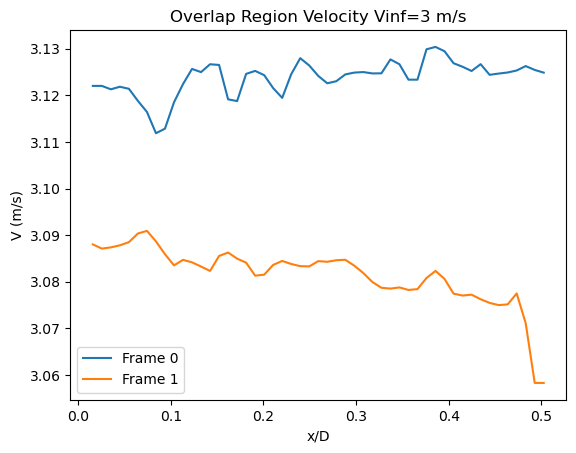

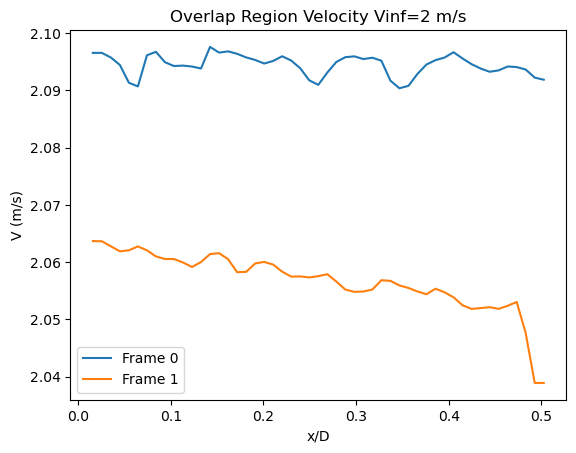

In [5]:
# Ovlap region plots

piv_vinf_3_frame0.corr_frame(frame0_x_corr, frame0_z_corr)
piv_vinf_3_frame0.reorient_frame(piv_disc_xc, piv_disc_zc)
piv_vinf_3_frame0.gen_data_intpr()

piv_vinf_3_frame1.reorient_frame(piv_disc_xc, piv_disc_zc)
piv_vinf_3_frame1.gen_data_intpr()

piv_vinf_2_frame0.corr_frame(frame0_x_corr, frame0_z_corr)
piv_vinf_2_frame0.reorient_frame(piv_disc_xc, piv_disc_zc)
piv_vinf_2_frame0.gen_data_intpr()

piv_vinf_2_frame1.reorient_frame(piv_disc_xc, piv_disc_zc)
piv_vinf_2_frame1.gen_data_intpr()

plot_x = np.linspace(piv_vinf_3_frame1.grid_x.max(), piv_vinf_3_frame0.grid_x.min(), 51)
plt.plot(plot_x, piv_vinf_3_frame0.grid_v_mag_intpr(plot_x, 0), label="Frame 0")
plt.plot(plot_x, piv_vinf_3_frame1.grid_v_mag_intpr(plot_x, 0), label="Frame 1")
plt.legend()
plt.xlabel("x/D")
plt.ylabel("V (m/s)")
plt.title("Overlap Region Velocity Vinf=3 m/s")
plt.figure()
plt.plot(plot_x, piv_vinf_2_frame0.grid_v_mag_intpr(plot_x, 0), label="Frame 0")
plt.plot(plot_x, piv_vinf_2_frame1.grid_v_mag_intpr(plot_x, 0), label="Frame 1")
plt.legend()
plt.xlabel("x/D")
plt.ylabel("V (m/s)")
plt.title("Overlap Region Velocity Vinf=2 m/s")

frame1 test (0,0): 3.08931 stitched:  3.08936
frame0 test (0.5,0): 3.12488 stitched:  3.1247


Text(0, 0.5, 'z/D')

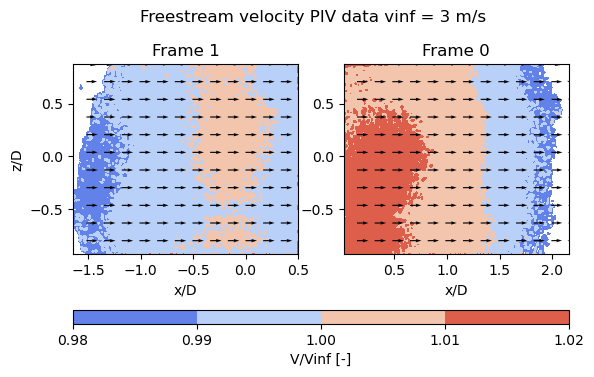

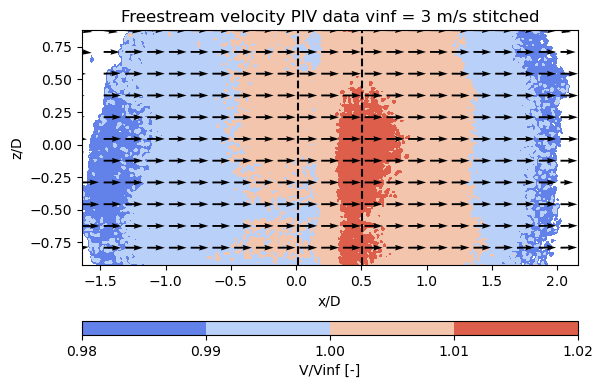

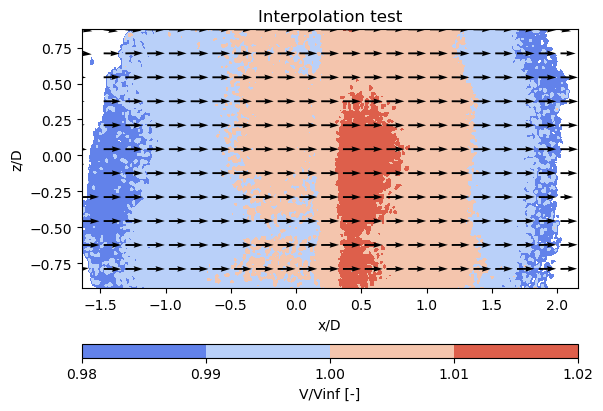

In [6]:
# Stitched data plots vinf = 3 m/s

piv_vinf_3_stitch = stitched_planar_piv_data()
piv_vinf_3_stitch.stitch_frames(piv_vinf_3_frame0, piv_vinf_3_frame1, piv_frame_res/200)
piv_vinf_3_stitch.gen_data_intpr()
print("frame1 test (0,0):", piv_vinf_3_frame1.grid_v_mag_intpr(0,0), "stitched: ", piv_vinf_3_stitch.grid_v_mag_intpr(0,0).round(5))
print("frame0 test (0.5,0):", piv_vinf_3_frame0.grid_v_mag_intpr(0.5,0), "stitched: ", piv_vinf_3_stitch.grid_v_mag_intpr(0.5,0).round(5))

plt.figure()
plt.suptitle("Freestream velocity PIV data vinf = 3 m/s", y=0.85)
plt.subplot(1,2,2)
mapping_plot = plt.contourf(piv_vinf_3_frame0.grid_x, piv_vinf_3_frame0.grid_z, piv_vinf_3_frame0.grid_v_mag/piv_vinf_3, levels=np.linspace(0.98,1.02,5), cmap='coolwarm')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.quiver(piv_vinf_3_frame0.grid_x[::25,::25], piv_vinf_3_frame0.grid_z[::25,::25], piv_vinf_3_frame0.grid_v_x[::25,::25]/piv_vinf_3, piv_vinf_3_frame0.grid_v_z[::25,::25]/piv_vinf_3, color='black')
plt.title("Frame 0")
plt.gca().set_aspect('equal')
plt.subplot(1,2,1)
plt.contourf(piv_vinf_3_frame1.grid_x, piv_vinf_3_frame1.grid_z, piv_vinf_3_frame1.grid_v_mag/piv_vinf_3, levels=np.linspace(0.98,1.02,5), cmap='coolwarm')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.quiver(piv_vinf_3_frame1.grid_x[::25,::25], piv_vinf_3_frame1.grid_z[::25,::25], piv_vinf_3_frame1.grid_v_x[::25,::25]/piv_vinf_3, piv_vinf_3_frame1.grid_v_z[::25,::25]/piv_vinf_3, color='black')
plt.title("Frame 1")
plt.gca().set_aspect('equal')
cax,kw = mpl.colorbar.make_axes([ax for ax in plt.gcf().axes],orientation="horizontal",aspect=35)
plt.colorbar(mapping_plot, cax=cax, **kw, label="V/Vinf [-]")
plt.figure()
plt.title("Freestream velocity PIV data vinf = 3 m/s stitched")
mapping_plot = plt.contourf(piv_vinf_3_stitch.grid_x, piv_vinf_3_stitch.grid_z, piv_vinf_3_stitch.grid_v_mag/piv_vinf_3, levels=np.linspace(0.98,1.02,5), cmap='coolwarm')
plt.quiver(piv_vinf_3_stitch.grid_x[::25,::25], piv_vinf_3_stitch.grid_z[::25,::25], piv_vinf_3_stitch.grid_v_x[::25,::25]/piv_vinf_3, piv_vinf_3_stitch.grid_v_z[::25,::25]/piv_vinf_3, color='black')
plt.colorbar(mappable = mapping_plot, orientation="horizontal", aspect=35, label="V/Vinf [-]")
plt.axvline(x=piv_vinf_3_frame1.grid_x.max(), color='black', linestyle="--")
plt.axvline(x=piv_vinf_3_frame0.grid_x.min(), color='black', linestyle="--")
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.gca().set_aspect('equal')
plt.figure()
plt.title("Interpolation test")
mapping_plot = plt.contourf(piv_vinf_3_stitch.grid_x, piv_vinf_3_stitch.grid_z, piv_vinf_3_stitch.grid_v_mag_intpr(piv_vinf_3_stitch.grid_x, piv_vinf_3_stitch.grid_z)/piv_vinf_3, levels=np.linspace(0.98,1.02,5), cmap='coolwarm')
plt.quiver(piv_vinf_3_stitch.grid_x[::25,::25], piv_vinf_3_stitch.grid_z[::25,::25], piv_vinf_3_stitch.grid_v_x_intpr(piv_vinf_3_stitch.grid_x[::25,::25], piv_vinf_3_stitch.grid_z[::25,::25])/piv_vinf_3, piv_vinf_3_stitch.grid_v_z_intpr(piv_vinf_3_stitch.grid_x[::25,::25], piv_vinf_3_stitch.grid_z[::25,::25])/piv_vinf_3, color='black')
plt.colorbar(mappable = mapping_plot, orientation="horizontal", aspect=35, label="V/Vinf [-]")
plt.xlabel("x/D")
plt.ylabel("z/D")

frame1 test (0,0): 2.06249 stitched:  2.06255
frame0 test (0.5,0): 2.09188 stitched:  2.09174


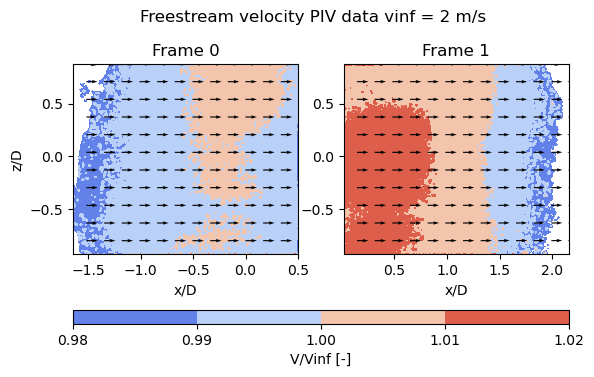

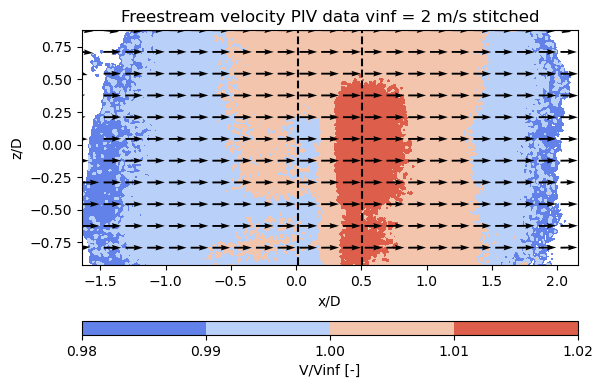

In [7]:
# Stitched data plots vinf = 2 m/s

piv_vinf_2_stitch = stitched_planar_piv_data()
piv_vinf_2_stitch.stitch_frames(piv_vinf_2_frame0, piv_vinf_2_frame1, piv_frame_res/200)
piv_vinf_2_stitch.gen_data_intpr()
print("frame1 test (0,0):", piv_vinf_2_frame1.grid_v_mag_intpr(0,0), "stitched: ", piv_vinf_2_stitch.grid_v_mag_intpr(0,0).round(5))
print("frame0 test (0.5,0):", piv_vinf_2_frame0.grid_v_mag_intpr(0.5,0), "stitched: ", piv_vinf_2_stitch.grid_v_mag_intpr(0.5,0).round(5))

plt.figure()
plt.suptitle("Freestream velocity PIV data vinf = 2 m/s", y=0.85)
plt.subplot(1,2,2)
mapping_plot = plt.contourf(piv_vinf_2_frame0.grid_x, piv_vinf_2_frame0.grid_z, piv_vinf_2_frame0.grid_v_mag/piv_vinf_2, levels=np.linspace(0.98,1.02,5), cmap='coolwarm')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.quiver(piv_vinf_2_frame0.grid_x[::25,::25], piv_vinf_2_frame0.grid_z[::25,::25], piv_vinf_2_frame0.grid_v_x[::25,::25]/piv_vinf_2, piv_vinf_2_frame0.grid_v_z[::25,::25]/piv_vinf_2, color='black')
plt.title("Frame 1")
plt.gca().set_aspect('equal')
plt.subplot(1,2,1)
plt.contourf(piv_vinf_2_frame1.grid_x, piv_vinf_2_frame1.grid_z, piv_vinf_2_frame1.grid_v_mag/piv_vinf_2, levels=np.linspace(0.98,1.02,5), cmap='coolwarm')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.quiver(piv_vinf_2_frame1.grid_x[::25,::25], piv_vinf_2_frame1.grid_z[::25,::25], piv_vinf_2_frame1.grid_v_x[::25,::25]/piv_vinf_2, piv_vinf_2_frame1.grid_v_z[::25,::25]/piv_vinf_2, color='black')
plt.title("Frame 0")
plt.gca().set_aspect('equal')
cax,kw = mpl.colorbar.make_axes([ax for ax in plt.gcf().axes],orientation="horizontal",aspect=35)
plt.colorbar(mapping_plot, cax=cax, **kw, label="V/Vinf [-]")
plt.figure()
plt.title("Freestream velocity PIV data vinf = 2 m/s stitched")
mapping_plot = plt.contourf(piv_vinf_2_stitch.grid_x, piv_vinf_2_stitch.grid_z, piv_vinf_2_stitch.grid_v_mag/piv_vinf_2, levels=np.linspace(0.98,1.02,5), cmap='coolwarm')
plt.quiver(piv_vinf_2_stitch.grid_x[::25,::25], piv_vinf_2_stitch.grid_z[::25,::25], piv_vinf_2_stitch.grid_v_x[::25,::25]/piv_vinf_2, piv_vinf_2_stitch.grid_v_z[::25,::25]/piv_vinf_2, color='black')
plt.colorbar(mappable = mapping_plot, orientation="horizontal", aspect=35, label="V/Vinf [-]")
plt.axvline(x=piv_vinf_2_frame1.grid_x.max(), color='black', linestyle="--")
plt.axvline(x=piv_vinf_2_frame0.grid_x.min(), color='black', linestyle="--")
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.gca().set_aspect('equal')

In [8]:
#Disc p70 import and condition data

piv_p70_case_06_phase_00_frame0, piv_p70_case_06_phase_00_frame1 = read_planar_piv_data(dataDir + "/surge_disc_2023_reprocess/p70_case_06_phase_00_0001.dat")
piv_p70_case_06_phase_00_frame0.corr_frame(frame0_x_corr, frame0_z_corr)
piv_p70_case_06_phase_00_frame0.reorient_frame(piv_disc_xc, piv_disc_zc)
piv_p70_case_06_phase_00_frame0.gen_data_intpr()

piv_p70_case_06_phase_00_frame1.reorient_frame(piv_disc_xc, piv_disc_zc)
piv_p70_case_06_phase_00_frame1.gen_data_intpr()

piv_p70_case_06_phase_00_stitch = stitched_planar_piv_data()
piv_p70_case_06_phase_00_stitch.stitch_frames(piv_p70_case_06_phase_00_frame0, piv_p70_case_06_phase_00_frame1, piv_frame_res/200)
piv_p70_case_06_phase_00_stitch.gen_data_intpr()

piv_p70_case_07_phase_00_frame0, piv_p70_case_07_phase_00_frame1 = read_planar_piv_data(dataDir + "/surge_disc_2023_reprocess/p70_case_07_phase_00_0001.dat")
piv_p70_case_07_phase_00_frame0.corr_frame(frame0_x_corr, frame0_z_corr)
piv_p70_case_07_phase_00_frame0.reorient_frame(piv_disc_xc, piv_disc_zc)
piv_p70_case_07_phase_00_frame0.gen_data_intpr()

piv_p70_case_07_phase_00_frame1.reorient_frame(piv_disc_xc, piv_disc_zc)
piv_p70_case_07_phase_00_frame1.gen_data_intpr()

piv_p70_case_07_phase_00_stitch = stitched_planar_piv_data()
piv_p70_case_07_phase_00_stitch.stitch_frames(piv_p70_case_07_phase_00_frame0, piv_p70_case_07_phase_00_frame1, piv_frame_res/200)
piv_p70_case_07_phase_00_stitch.gen_data_intpr()


In [9]:
# freesstream velocity at disc centre

piv_vinf_3_disc_centre = piv_vinf_3_stitch.grid_v_mag_intpr(0,0)
piv_vinf_2_disc_centre = piv_vinf_2_stitch.grid_v_mag_intpr(0,0)
print("Vinf=3 m/s at disc centre: ", piv_vinf_3_disc_centre.round(3), "Vinf=2 m/s at disc centre: ", piv_vinf_2_disc_centre.round(3))
print("Average Vinf=3 m/s: ", piv_vinf_3, "Average Vinf=2 m/s: ", piv_vinf_2)

Vinf=3 m/s at disc centre:  3.089 Vinf=2 m/s at disc centre:  2.063
Average Vinf=3 m/s:  3.086 Average Vinf=2 m/s:  2.063


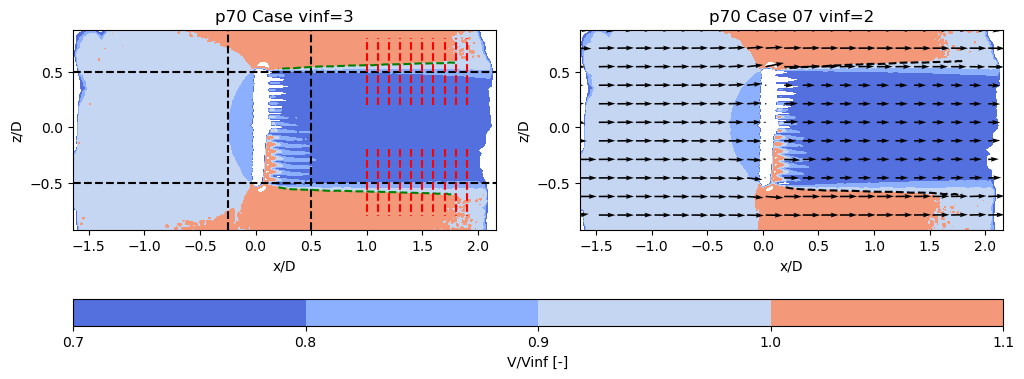

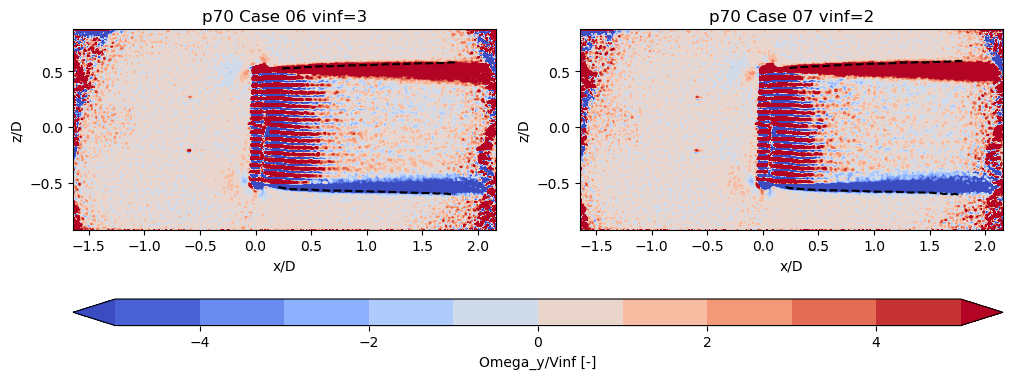

In [105]:
# Disc p70 plots

p70_case_06_phase_00_upper_stube_cntr, p70_case_06_phase_00_lower_stube_cntr = piv_p70_case_06_phase_00_stitch.get_stube_bndry(0.2, 1.8, piv_vinf_3, 0.99)
p70_case_07_phase_00_upper_stube_cntr, p70_case_07_phase_00_lower_stube_cntr = piv_p70_case_07_phase_00_stitch.get_stube_bndry(0.2, 1.8, piv_vinf_2, 0.99)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.axvline(x=-0.25, color='black', linestyle='--')
plt.axvline(x=0.50, color='black', linestyle='--')
plt.axhline(y=-0.5, color='black', linestyle='--')
plt.axhline(y=0.50, color='black', linestyle='--')
mapping_plot = plt.contourf(piv_p70_case_06_phase_00_stitch.grid_x, piv_p70_case_06_phase_00_stitch.grid_z, piv_p70_case_06_phase_00_stitch.grid_v_mag/piv_vinf_3, norm = mpl.colors.TwoSlopeNorm(vmin=0.7, vcenter=1.0, vmax=1.1), levels=np.linspace(0.7,1.1,5), cmap='coolwarm')
plt.plot(p70_case_06_phase_00_upper_stube_cntr[:,0], p70_case_06_phase_00_upper_stube_cntr[:,1], color='green', linestyle='--')
plt.plot(p70_case_06_phase_00_lower_stube_cntr[:,0], p70_case_06_phase_00_lower_stube_cntr[:,1], color='green', linestyle='--')
# plt.quiver(piv_p70_case_06_phase_00_stitch.grid_x[::25,::25], piv_p70_case_06_phase_00_stitch.grid_z[::25,::25], piv_p70_case_06_phase_00_stitch.grid_v_x[::25,::25]/piv_vinf_3, piv_p70_case_06_phase_00_stitch.grid_v_z[::25,::25]/piv_vinf_3, color='black')
[plt.plot([x,x],[0.2,0.8], color="red", linestyle="--" ) for x in np.linspace(1,1.9,10)]
[plt.plot([x,x],[-0.2,-0.8], color="red", linestyle="--" ) for x in np.linspace(1,1.9,10)]
plt.gca().set_aspect('equal')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.title("p70 Case vinf=3")
plt.subplot(1,2,2)
plt.contourf(piv_p70_case_07_phase_00_stitch.grid_x, piv_p70_case_07_phase_00_stitch.grid_z, piv_p70_case_07_phase_00_stitch.grid_v_mag/piv_vinf_2, norm = mpl.colors.TwoSlopeNorm(vmin=0.7, vcenter=1.0, vmax=1.1), levels=np.linspace(0.7,1.1,5), cmap='coolwarm')
plt.plot(p70_case_07_phase_00_upper_stube_cntr[:,0], p70_case_07_phase_00_upper_stube_cntr[:,1], color='black', linestyle='--')
plt.plot(p70_case_07_phase_00_lower_stube_cntr[:,0], p70_case_07_phase_00_lower_stube_cntr[:,1], color='black', linestyle='--')
plt.quiver(piv_p70_case_07_phase_00_stitch.grid_x[::25,::25], piv_p70_case_07_phase_00_stitch.grid_z[::25,::25], piv_p70_case_07_phase_00_stitch.grid_v_x[::25,::25]/piv_vinf_2, piv_p70_case_07_phase_00_stitch.grid_v_z[::25,::25]/piv_vinf_2, color='black')
plt.gca().set_aspect('equal')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.title("p70 Case 07 vinf=2")
cax,kw = mpl.colorbar.make_axes([ax for ax in plt.gcf().axes],orientation="horizontal",aspect=35)
plt.colorbar(mapping_plot, cax=cax, **kw, label="V/Vinf [-]")

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
mapping_plot = plt.contourf(piv_p70_case_06_phase_00_stitch.grid_x, piv_p70_case_06_phase_00_stitch.grid_z, piv_p70_case_06_phase_00_stitch.grid_omega_y/piv_vinf_3, levels=np.linspace(-5,5,11), cmap='coolwarm', extend='both')
plt.plot(p70_case_06_phase_00_upper_stube_cntr[:,0], p70_case_06_phase_00_upper_stube_cntr[:,1], color='black', linestyle='--')
plt.plot(p70_case_06_phase_00_lower_stube_cntr[:,0], p70_case_06_phase_00_lower_stube_cntr[:,1], color='black', linestyle='--')
plt.gca().set_aspect('equal')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.title("p70 Case 06 vinf=3")
plt.subplot(1,2,2)
plt.contourf(piv_p70_case_07_phase_00_stitch.grid_x, piv_p70_case_07_phase_00_stitch.grid_z, piv_p70_case_07_phase_00_stitch.grid_omega_y/piv_vinf_2, levels=np.linspace(-5,5,11), cmap='coolwarm', extend='both')
plt.plot(p70_case_07_phase_00_upper_stube_cntr[:,0], p70_case_07_phase_00_upper_stube_cntr[:,1], color='black', linestyle='--')
plt.plot(p70_case_07_phase_00_lower_stube_cntr[:,0], p70_case_07_phase_00_lower_stube_cntr[:,1], color='black', linestyle='--')
plt.gca().set_aspect('equal')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.title("p70 Case 07 vinf=2")
cax,kw = mpl.colorbar.make_axes([ax for ax in plt.gcf().axes],orientation="horizontal",aspect=35)
plt.colorbar(mapping_plot, cax=cax, **kw, label="Omega_y/Vinf [-]")

p70 case 06 phase 00 effective induction at x/D = 0:  0.134
p70 case 07 phase 00 effective induction at x/D = 0:  0.159
p70 case 06 phase 00 effective induction (smoothing) at x/D = 0:  0.13
p70 case 07 phase 00 effective induction (smoothing) at x/D = 0:  0.152


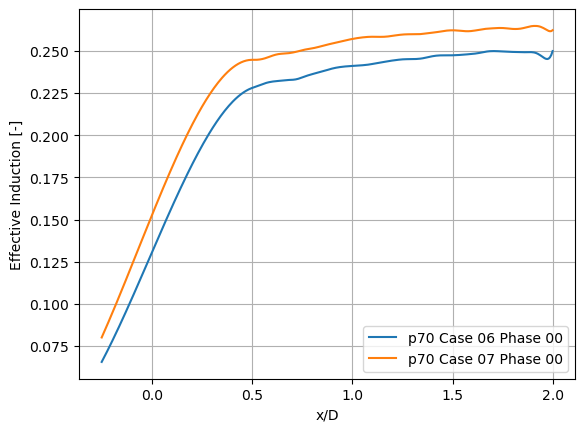

In [11]:
# Disc p70 effective induction plots

x_ustream_plot = np.arange(-0.25, -0.05, piv_frame_res/200)
x_dstream_plot = np.arange(0.2, 2, piv_frame_res/200)
x_plot = np.arange(-0.25, 2, piv_frame_res/200)

print("p70 case 06 phase 00 effective induction at x/D = 0: ", piv_p70_case_06_phase_00_stitch.get_eff_ind_intpr(piv_vinf_3,-0.25,0.5,smooth=False)(0).round(3))
print("p70 case 07 phase 00 effective induction at x/D = 0: ", piv_p70_case_07_phase_00_stitch.get_eff_ind_intpr(piv_vinf_2,-0.25,0.5,smooth=False)(0).round(3))
print("p70 case 06 phase 00 effective induction (smoothing) at x/D = 0: ", piv_p70_case_06_phase_00_stitch.get_eff_ind_intpr(piv_vinf_3,-0.25,0.5)(0).round(3))
print("p70 case 07 phase 00 effective induction (smoothing) at x/D = 0: ", piv_p70_case_07_phase_00_stitch.get_eff_ind_intpr(piv_vinf_2,-0.25,0.5)(0).round(3))

plt.plot(x_plot, piv_p70_case_06_phase_00_stitch.get_eff_ind_intpr(piv_vinf_3,-0.25,0.5)(x_plot), label="p70 Case 06 Phase 00")
plt.plot(x_plot, piv_p70_case_07_phase_00_stitch.get_eff_ind_intpr(piv_vinf_2,-0.25,0.5)(x_plot), label="p70 Case 07 Phase 00")
plt.xlabel("x/D")
plt.ylabel("Effective Induction [-]")
plt.legend()
plt.grid()


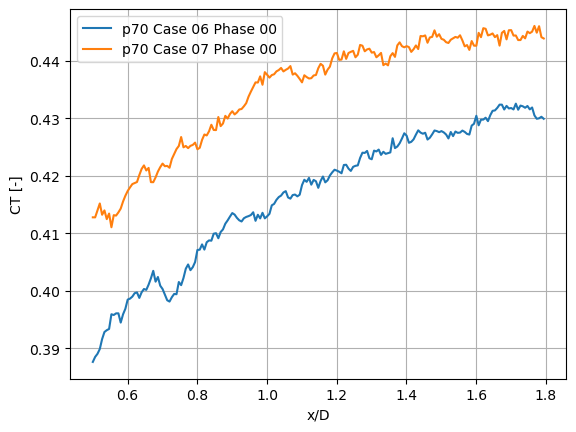

In [12]:
# Disc p70 CT mom deficit plots

x_min = 0.5
x_max = 1.8

x_arr, p70_case_06_phase_00_CT_arr = piv_p70_case_06_phase_00_stitch.get_CT_mom_deficit(x_min, x_max, piv_vinf_3, piv_rho_inf, 0.99)
x_arr, p70_case_07_phase_00_CT_arr = piv_p70_case_07_phase_00_stitch.get_CT_mom_deficit(x_min, x_max, piv_vinf_2, piv_rho_inf, 0.99)

plt.plot(x_arr, p70_case_06_phase_00_CT_arr, label="p70 Case 06 Phase 00")
plt.plot(x_arr, p70_case_07_phase_00_CT_arr, label="p70 Case 07 Phase 00")
plt.xlabel("x/D")
plt.ylabel("CT [-]")
plt.legend()
plt.grid()


0.025000000000000022
0.025000000000000022


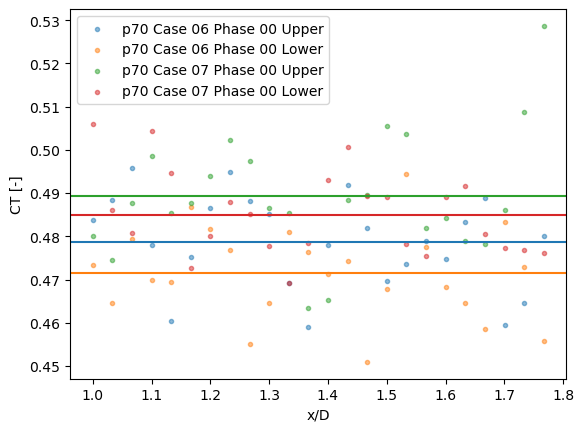

In [13]:
# Disc p70 CT vort flux plots

x_min = 1
x_max = 1.8

x_arr, p70_case_06_phase_00_CT_upper_arr, p70_case_06_phase_00_CT_lower_arr = piv_p70_case_06_phase_00_stitch.get_CT_vort_flux(x_min, x_max, piv_vinf_3, 0.3)
x_arr, p70_case_07_phase_00_CT_upper_arr, p70_case_07_phase_00_CT_lower_arr = piv_p70_case_07_phase_00_stitch.get_CT_vort_flux(x_min, x_max, piv_vinf_2, 0.3)

plt.scatter(x_arr, p70_case_06_phase_00_CT_upper_arr, label="p70 Case 06 Phase 00 Upper", marker=".", alpha=0.5)
plt.axhline(np.mean(p70_case_06_phase_00_CT_upper_arr), color='tab:blue')
plt.scatter(x_arr, np.absolute(p70_case_06_phase_00_CT_lower_arr), label="p70 Case 06 Phase 00 Lower", marker=".", alpha=0.5)
plt.axhline(np.mean(np.absolute(p70_case_06_phase_00_CT_lower_arr)), color='tab:orange')
plt.scatter(x_arr, p70_case_07_phase_00_CT_upper_arr, label="p70 Case 07 Phase 00 Upper", marker=".", alpha=0.5)
plt.axhline(np.mean(p70_case_07_phase_00_CT_upper_arr), color='tab:green')
plt.scatter(x_arr, np.absolute(p70_case_07_phase_00_CT_lower_arr), label="p70 Case 07 Phase 00 Lower", marker=".", alpha=0.5)
plt.axhline(np.mean(np.absolute(p70_case_07_phase_00_CT_lower_arr)), color='tab:red')
plt.xlabel("x/D")
plt.ylabel("CT [-]")
plt.legend()

In [14]:
# Import and condition data for disc p45

piv_p45_case_06_phase_00_frame0, piv_p45_case_06_phase_00_frame1 = read_planar_piv_data(dataDir + "/surge_disc_2023_reprocess/p45_case_06_phase_00_0001.dat")
piv_p45_case_06_phase_00_frame0.corr_frame(frame0_x_corr, frame0_z_corr)
piv_p45_case_06_phase_00_frame0.reorient_frame(piv_disc_xc, piv_disc_zc)
piv_p45_case_06_phase_00_frame0.gen_data_intpr()

piv_p45_case_06_phase_00_frame1.reorient_frame(piv_disc_xc, piv_disc_zc)
piv_p45_case_06_phase_00_frame1.gen_data_intpr()

piv_p45_case_06_phase_00_stitch = stitched_planar_piv_data()
piv_p45_case_06_phase_00_stitch.stitch_frames(piv_p45_case_06_phase_00_frame0, piv_p45_case_06_phase_00_frame1, piv_frame_res/200)
piv_p45_case_06_phase_00_stitch.gen_data_intpr()

piv_p45_case_07_phase_00_frame0, piv_p45_case_07_phase_00_frame1 = read_planar_piv_data(dataDir + "/surge_disc_2023_reprocess/p45_case_07_phase_00_0001.dat")
piv_p45_case_07_phase_00_frame0.corr_frame(frame0_x_corr, frame0_z_corr)
piv_p45_case_07_phase_00_frame0.reorient_frame(piv_disc_xc, piv_disc_zc)
piv_p45_case_07_phase_00_frame0.gen_data_intpr()

piv_p45_case_07_phase_00_frame1.reorient_frame(piv_disc_xc, piv_disc_zc)
piv_p45_case_07_phase_00_frame1.gen_data_intpr()

piv_p45_case_07_phase_00_stitch = stitched_planar_piv_data()
piv_p45_case_07_phase_00_stitch.stitch_frames(piv_p45_case_07_phase_00_frame0, piv_p45_case_07_phase_00_frame1, piv_frame_res/200)
piv_p45_case_07_phase_00_stitch.gen_data_intpr()

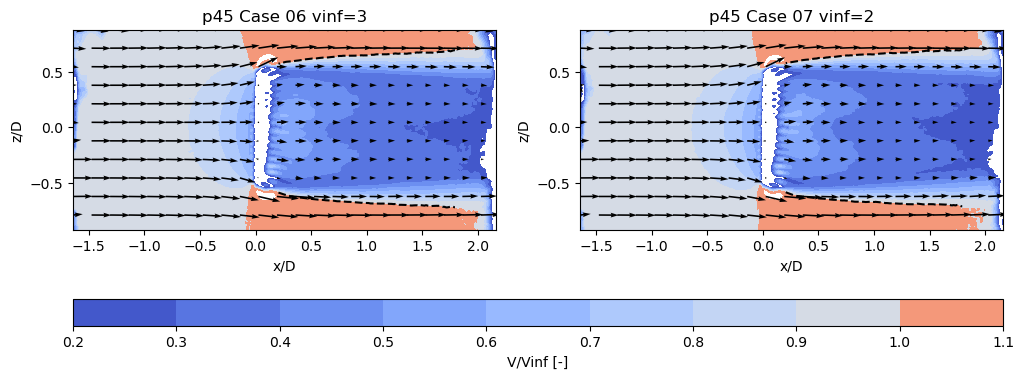

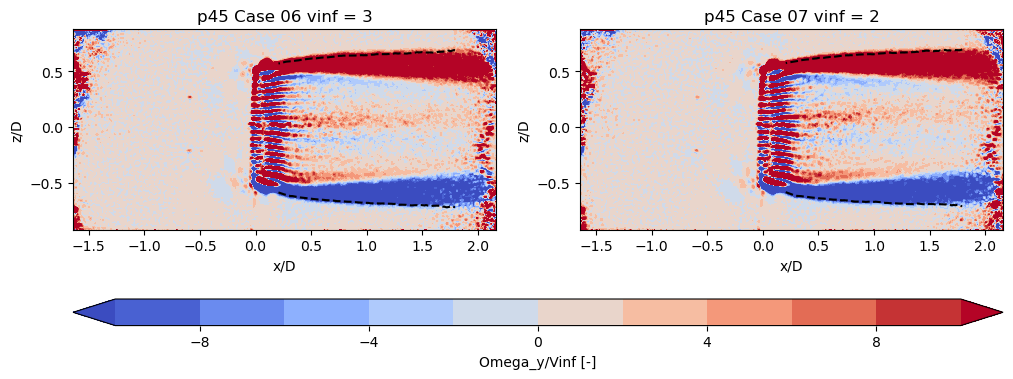

In [92]:
# Disc p45 plots

p45_case_06_phase_00_upper_stube_cntr, p45_case_06_phase_00_lower_stube_cntr = piv_p45_case_06_phase_00_stitch.get_stube_bndry(0.2, 1.8, piv_vinf_3, 0.99)
p45_case_07_phase_00_upper_stube_cntr, p45_case_07_phase_00_lower_stube_cntr = piv_p45_case_07_phase_00_stitch.get_stube_bndry(0.2, 1.8, piv_vinf_2, 0.99)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
mapping_plot = plt.contourf(piv_p45_case_06_phase_00_stitch.grid_x, piv_p45_case_06_phase_00_stitch.grid_z, piv_p45_case_06_phase_00_stitch.grid_v_mag/piv_vinf_3, norm = mpl.colors.TwoSlopeNorm(vmin=0.2, vcenter=1.0, vmax=1.1), levels=np.linspace(0.2,1.1,10), cmap='coolwarm')
plt.plot(p45_case_06_phase_00_upper_stube_cntr[:,0], p45_case_06_phase_00_upper_stube_cntr[:,1], color='black', linestyle='--')
plt.plot(p45_case_06_phase_00_lower_stube_cntr[:,0], p45_case_06_phase_00_lower_stube_cntr[:,1], color='black', linestyle='--')
plt.quiver(piv_p45_case_06_phase_00_stitch.grid_x[::25,::25], piv_p45_case_06_phase_00_stitch.grid_z[::25,::25], piv_p45_case_06_phase_00_stitch.grid_v_x[::25,::25]/piv_vinf_3, piv_p45_case_06_phase_00_stitch.grid_v_z[::25,::25]/piv_vinf_3, color='black')
plt.gca().set_aspect('equal')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.title("p45 Case 06 vinf=3")
plt.subplot(1,2,2)
plt.contourf(piv_p45_case_07_phase_00_stitch.grid_x, piv_p45_case_07_phase_00_stitch.grid_z, piv_p45_case_07_phase_00_stitch.grid_v_mag/piv_vinf_2, norm = mpl.colors.TwoSlopeNorm(vmin=0.2, vcenter=1.0, vmax=1.1), levels=np.linspace(0.2,1.1,10), cmap='coolwarm')
plt.plot(p45_case_07_phase_00_upper_stube_cntr[:,0], p45_case_07_phase_00_upper_stube_cntr[:,1], color='black', linestyle='--')
plt.plot(p45_case_07_phase_00_lower_stube_cntr[:,0], p45_case_07_phase_00_lower_stube_cntr[:,1], color='black', linestyle='--')
plt.quiver(piv_p45_case_07_phase_00_stitch.grid_x[::25,::25], piv_p45_case_07_phase_00_stitch.grid_z[::25,::25], piv_p45_case_07_phase_00_stitch.grid_v_x[::25,::25]/piv_vinf_2, piv_p45_case_07_phase_00_stitch.grid_v_z[::25,::25]/piv_vinf_2, color='black')
plt.gca().set_aspect('equal')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.title("p45 Case 07 vinf=2")
cax, kw = mpl.colorbar.make_axes([ax for ax in plt.gcf().axes], orientation="horizontal", aspect=35)
plt.colorbar(mapping_plot, cax=cax, **kw, label="V/Vinf [-]")

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
mapping_plot = plt.contourf(piv_p45_case_06_phase_00_stitch.grid_x, piv_p45_case_06_phase_00_stitch.grid_z, piv_p45_case_06_phase_00_stitch.grid_omega_y/piv_vinf_3, levels=np.linspace(-10,10,11), cmap='coolwarm', extend='both')
plt.plot(p45_case_06_phase_00_upper_stube_cntr[:,0], p45_case_06_phase_00_upper_stube_cntr[:,1], color='black', linestyle='--')
plt.plot(p45_case_06_phase_00_lower_stube_cntr[:,0], p45_case_06_phase_00_lower_stube_cntr[:,1], color='black', linestyle='--')
plt.gca().set_aspect('equal')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.title("p45 Case 06 vinf = 3")
plt.subplot(1,2,2)
plt.contourf(piv_p45_case_07_phase_00_stitch.grid_x, piv_p45_case_07_phase_00_stitch.grid_z, piv_p45_case_07_phase_00_stitch.grid_omega_y/piv_vinf_2, levels=np.linspace(-10,10,11), cmap='coolwarm', extend='both')
plt.plot(p45_case_07_phase_00_upper_stube_cntr[:,0], p45_case_07_phase_00_upper_stube_cntr[:,1], color='black', linestyle='--')
plt.plot(p45_case_07_phase_00_lower_stube_cntr[:,0], p45_case_07_phase_00_lower_stube_cntr[:,1], color='black', linestyle='--')
plt.gca().set_aspect('equal')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.title("p45 Case 07 vinf = 2")
cax, kw = mpl.colorbar.make_axes([ax for ax in plt.gcf().axes], orientation="horizontal", aspect=35)
plt.colorbar(mapping_plot, cax=cax, **kw, label="Omega_y/Vinf [-]")

p45 case 06 phase 00 effective induction at x/D = 0:  0.336
p45 case 07 phase 00 effective induction at x/D = 0:  0.351
p45 case 06 phase 00 effective induction (smoothing) at x/D = 0:  0.335
p45 case 07 phase 00 effective induction (smoothing) at x/D = 0:  0.345


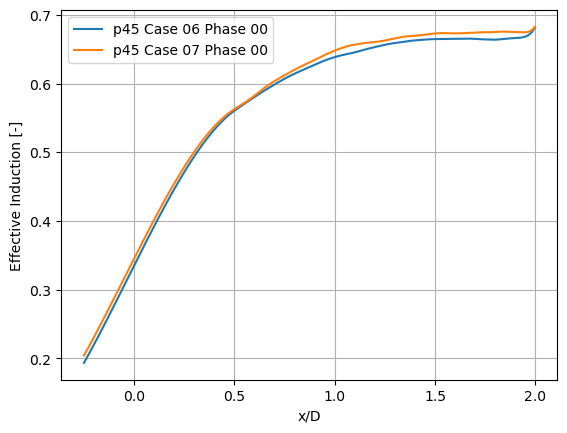

In [16]:
# Disc p45 effective induction plots

x_plot = np.arange(-0.25, 2, piv_frame_res/200)

print("p45 case 06 phase 00 effective induction at x/D = 0: ", piv_p45_case_06_phase_00_stitch.get_eff_ind_intpr(piv_vinf_3, -0.25, 0.5, smooth=False)(0).round(3))
print("p45 case 07 phase 00 effective induction at x/D = 0: ", piv_p45_case_07_phase_00_stitch.get_eff_ind_intpr(piv_vinf_2, -0.25, 0.5, smooth=False)(0).round(3))
print("p45 case 06 phase 00 effective induction (smoothing) at x/D = 0: ", piv_p45_case_06_phase_00_stitch.get_eff_ind_intpr(piv_vinf_3, -0.25, 0.5)(0).round(3))
print("p45 case 07 phase 00 effective induction (smoothing) at x/D = 0: ", piv_p45_case_07_phase_00_stitch.get_eff_ind_intpr(piv_vinf_2, -0.25, 0.5)(0).round(3))

plt.plot(x_plot, piv_p45_case_06_phase_00_stitch.get_eff_ind_intpr(piv_vinf_3, -0.25, 0.5)(x_plot), label="p45 Case 06 Phase 00")
plt.plot(x_plot, piv_p45_case_07_phase_00_stitch.get_eff_ind_intpr(piv_vinf_2, -0.25, 0.5)(x_plot), label="p45 Case 07 Phase 00")
plt.xlabel("x/D")
plt.ylabel("Effective Induction [-]")
plt.legend()
plt.grid()

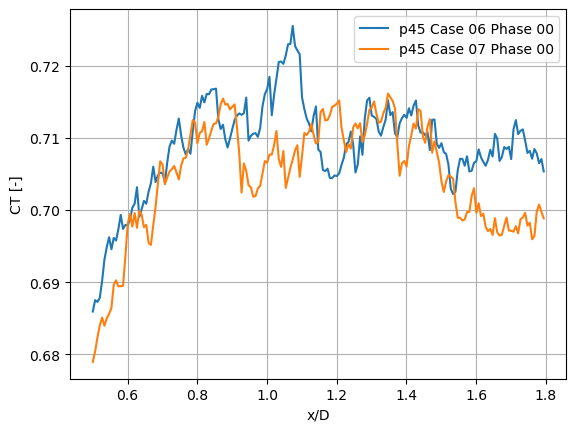

In [17]:
# Disc P45 CT mom deficit plots

x_min = 0.5
x_max = 1.8

x_arr, p45_case_06_phase_00_CT_arr = piv_p45_case_06_phase_00_stitch.get_CT_mom_deficit(x_min, x_max, piv_vinf_3, piv_rho_inf, 0.99)
x_arr, p45_case_07_phase_00_CT_arr = piv_p45_case_07_phase_00_stitch.get_CT_mom_deficit(x_min, x_max, piv_vinf_2, piv_rho_inf, 0.99)

plt.plot(x_arr, p45_case_06_phase_00_CT_arr, label="p45 Case 06 Phase 00")
plt.plot(x_arr, p45_case_07_phase_00_CT_arr, label="p45 Case 07 Phase 00")
plt.xlabel("x/D")
plt.ylabel("CT [-]")
plt.legend()
plt.grid()

0.025000000000000022
0.025000000000000022


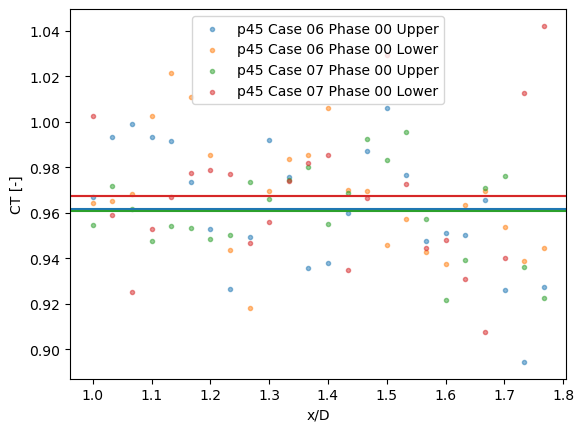

In [18]:
# p45 CT vort flux plots

x_min = 1
x_max = 1.8

x_arr, p45_case_06_phase_00_CT_upper_arr, p45_case_06_phase_00_CT_lower_arr = piv_p45_case_06_phase_00_stitch.get_CT_vort_flux(x_min, x_max, piv_vinf_3, 0.3)
x_arr, p45_case_07_phase_00_CT_upper_arr, p45_case_07_phase_00_CT_lower_arr = piv_p45_case_07_phase_00_stitch.get_CT_vort_flux(x_min, x_max, piv_vinf_2, 0.3)

plt.scatter(x_arr, p45_case_06_phase_00_CT_upper_arr, label="p45 Case 06 Phase 00 Upper", marker=".", alpha=0.5)
plt.axhline(np.mean(p45_case_06_phase_00_CT_upper_arr), color='tab:blue')
plt.scatter(x_arr, np.absolute(p45_case_06_phase_00_CT_lower_arr), label="p45 Case 06 Phase 00 Lower", marker=".", alpha=0.5)
plt.axhline(np.mean(np.absolute(p45_case_06_phase_00_CT_lower_arr)), color='tab:orange')
plt.scatter(x_arr, p45_case_07_phase_00_CT_upper_arr, label="p45 Case 07 Phase 00 Upper", marker=".", alpha=0.5)
plt.axhline(np.mean(p45_case_07_phase_00_CT_upper_arr), color='tab:green')
plt.scatter(x_arr, np.absolute(p45_case_07_phase_00_CT_lower_arr), label="p45 Case 07 Phase 00 Lower", marker=".", alpha=0.5)
plt.axhline(np.mean(np.absolute(p45_case_07_phase_00_CT_lower_arr)), color='tab:red')
plt.xlabel("x/D")
plt.ylabel("CT [-]")
plt.legend()

In [27]:
# ptv data structure and definition

class vol_ptv_data:
    """
    A class to handle volumetric Particle Tracking Velocimetry (PTV) data.
    Attributes:
    -----------
    deflt_grid_x : np.ndarray
        Default x-coordinates of the grid points.
    deflt_grid_y : np.ndarray
        Default y-coordinates of the grid points.
    deflt_grid_z : np.ndarray
        Default z-coordinates of the grid points.
    grid_x : np.ndarray
        Current x-coordinates of the grid points.
    grid_y : np.ndarray
        Current y-coordinates of the grid points.
    grid_z : np.ndarray
        Current z-coordinates of the grid points.
    grid_v_x : np.ndarray
        x-component of the velocity at the grid points.
    grid_v_y : np.ndarray
        y-component of the velocity at the grid points.
    grid_v_z : np.ndarray
        z-component of the velocity at the grid points.
    grid_v_mag : np.ndarray
        Magnitude of the velocity at the grid points.
    grid_omega_x : np.ndarray
        x-component of the vorticity at the grid points.
    grid_omega_y : np.ndarray
        y-component of the vorticity at the grid points.
    grid_omega_z : np.ndarray
        z-component of the vorticity at the grid points.
    grid_omega_mag : np.ndarray
        Magnitude of the vorticity at the grid points.
    grid_p : np.ndarray
        Pressure at the grid points.
    grid_r_xx : np.ndarray
        Reynolds stress component at the grid points.
    grid_valid_cell : np.ndarray
        Boolean array indicating valid cells in the grid.
    Methods:
    --------
    __init__(frame_i, frame_j, frame_k, frame_data):
        Initializes the vol_ptv_data object with the given frame dimensions and data.
    reorient_frame(x_c, y_c, z_c):
        Reorients the frame by scaling the grid coordinates.
    gen_intpr():
        Generates interpolators for the grid data, excluding the coordinates
    """
    
    def __init__(self, frame_i, frame_j, frame_k, frame_data):
        
        self.deflt_grid_x = frame_data[:,0].reshape(frame_i, frame_j, frame_k, order='F')
        self.deflt_grid_y = frame_data[:,1].reshape(frame_i, frame_j, frame_k, order='F')
        self.deflt_grid_z = frame_data[:,2].reshape(frame_i, frame_j, frame_k, order='F')
        
        self.grid_x = deepcopy(self.deflt_grid_x)
        self.grid_y = deepcopy(self.deflt_grid_y)
        self.grid_z = deepcopy(self.deflt_grid_z)
        
        self.grid_v_x = frame_data[:,3].reshape(frame_i, frame_j, frame_k, order="F")
        self.grid_v_y = frame_data[:,4].reshape(frame_i, frame_j, frame_k, order="F")
        self.grid_v_z = frame_data[:,5].reshape(frame_i, frame_j, frame_k, order="F")
        self.grid_v_mag = frame_data[:,6].reshape(frame_i, frame_j, frame_k, order="F")
        
        self.grid_omega_x = frame_data[:,7].reshape(frame_i, frame_j, frame_k, order="F")
        self.grid_omega_y = frame_data[:,8].reshape(frame_i, frame_j, frame_k, order="F")
        self.grid_omega_z = frame_data[:,9].reshape(frame_i, frame_j, frame_k, order="F")
        self.grid_omega_mag = frame_data[:,10].reshape(frame_i, frame_j, frame_k, order="F")
        
        self.grid_p = frame_data[:,11].reshape(frame_i, frame_j, frame_k, order="F")
        self.grid_r_xx = frame_data[:,12].reshape(frame_i, frame_j, frame_k, order="F")
        
        self.grid_valid_cell = frame_data[:,13].reshape(frame_i, frame_j, frame_k, order="F").astype(bool)
        
    def reorient_frame(self, x_c, y_c, z_c):
        """
        Reorients the frame of reference for the grid coordinates.
        This method adjusts the grid coordinates by subtracting the provided
        center coordinates (x_c, y_c, z_c) and then normalizes the coordinates
        by dividing by 200.
        Parameters:
        x_c (float): The x-coordinate of the new center.
        y_c (float): The y-coordinate of the new center.
        z_c (float): The z-coordinate of the new center.
        Returns:
        None
        """
        
        self.grid_x = deepcopy(self.deflt_grid_x)
        self.grid_y = deepcopy(self.deflt_grid_y)
        self.grid_z = deepcopy(self.deflt_grid_z)
        
        self.grid_x = self.grid_x - x_c
        self.grid_y = self.grid_y - y_c
        self.grid_z = self.grid_z - z_c
        
        self.grid_x /= 200
        self.grid_y /= 200
        self.grid_z /= 200
        
    def gen_intpr(self):
        """
        Generates interpolators for grid data attributes.
        This method inspects the instance for attributes matching the pattern "grid*".
        For each matching attribute (excluding "grid_x", "grid_y", "grid_z", and "grid_valid_cell"),
        it sets invalid cells (where `grid_valid_cell` is False) to NaN and creates a 
        `RegularGridInterpolator` for the attribute with nearest neighbor interpolation.
        The interpolator is stored in a new attribute with the suffix "_intpr".
        Additionally, an interpolator for `grid_valid_cell` is created and stored in 
        `grid_valid_cell_intpr`.
        Returns:
            None
        """
        
        for name, value in inspect.getmembers(self):
            
            if fnmatch.fnmatch(name, "grid*intpr"): 
                return
        
        for name, value in inspect.getmembers(self):
            
            if fnmatch.fnmatch(name, "grid*") and name != "grid_x" and name != "grid_y" and name != "grid_z" and name != "grid_valid_cell":
                
                getattr(self, name)[np.logical_not(self.grid_valid_cell)] = np.nan
                setattr(self, name + "_intpr", RegularGridInterpolator((self.grid_x[:,0,0], self.grid_y[0,:,0], self.grid_z[0,0,:]), getattr(self, name), method="nearest"))
                
        self.grid_valid_cell_intpr = RegularGridInterpolator((self.grid_x[:,0,0], self.grid_y[0,:,0], self.grid_z[0,0,:]), self.grid_valid_cell, method="nearest", bounds_error=False, fill_value=0)
        
    def get_eff_ind(self, x, v_inf):
        """
        Calculate the effective induced velocity at a given position.
        Parameters:
        -----------
        x : float
            The x-coordinate at which to evaluate the induced velocity.
        v_inf : float
            The free-stream velocity.
        Returns:
        --------
        eff_ind : float
            The effective induced velocity normalized by the free-stream velocity.
        Notes:
        ------
        This method calculates the effective induced velocity by integrating over a semi-disc area.
        The semi-disc is discretized into a grid in polar coordinates (psi, r), and the induced velocity
        is interpolated at the grid points. The effective induced velocity is then computed as the
        area-weighted average of the induced velocity over the semi-disc.
        """
        
        semi_disc_area = 0.5 * np.pi * (0.5)**2
        
        psi_arr = np.linspace(-np.pi/2, np.pi/2, 41)
        r_arr = np.linspace(0, 0.5, 21)
        
        psi_cp_arr = 0.5*(psi_arr[1:] + psi_arr[:-1])
        r_cp_arr = 0.5*(r_arr[1:] + r_arr[:-1])
        grid_psi_cp, grid_r_cp = np.meshgrid(psi_cp_arr, r_cp_arr, indexing="ij")
        delta_psi = psi_arr[1] - psi_arr[0]
        delta_r = r_arr[1] - r_arr[0]
        
        grid_y = r_cp_arr * np.sin(grid_psi_cp)
        grid_z = r_cp_arr * np.cos(grid_psi_cp)
        
        discr_ind = (v_inf - self.grid_v_x_intpr(np.column_stack((np.tile(x, len(r_cp_arr)*len(psi_cp_arr)), grid_y.flatten(), grid_z.flatten()))).reshape(grid_y.shape))/v_inf
        discr_area = delta_psi * delta_r * grid_r_cp
        eff_ind = np.sum(discr_ind * discr_area)/semi_disc_area
        
        return eff_ind
    
    def get_eff_ind_intpr(self, v_inf, x_ustream_fin=-0.1, x_dstream_init=0.2, smooth=True):
        """
        Interpolates the effective induced velocity over a specified range of x-coordinates.
        Parameters:
        -----------
        v_inf : float
            The free-stream velocity.
        x_ustream_fin : float, optional
            The final x-coordinate upstream of the object (default is -0.1).
        x_dstream_init : float, optional
            The initial x-coordinate downstream of the object (default is 0.2).
        smooth : bool, optional
            If True, applies a low-pass filter to smooth the effective induced velocity arrays (default is True) enhancing the effectiveness of interpolation.
        Returns:
        --------
        CubicSpline
            A cubic spline interpolation of the effective induced velocity over the concatenated upstream and downstream x-coordinates.
        """
        
        
        delta_x = self.grid_x[1,0,0] - self.grid_x[0,0,0]
        x_ustream_arr = np.arange(-0.5,x_ustream_fin,delta_x)
        x_dstream_arr = np.arange(x_dstream_init,self.grid_x.max(),delta_x)
        
        eff_ind_ustream_arr = np.array([self.get_eff_ind(x, v_inf) for x in x_ustream_arr])
        eff_ind_dstream_arr = np.array([self.get_eff_ind(x, v_inf) for x in x_dstream_arr])
        
        mask_ustream = np.logical_not(np.isnan(eff_ind_ustream_arr))
        mask_dstream = np.logical_not(np.isnan(eff_ind_dstream_arr))
        
        if smooth:
        
            eff_ind_ustream_arr = low_pass_filt(eff_ind_ustream_arr, 1/delta_x, 0.05/delta_x)
            eff_ind_dstream_arr = low_pass_filt(eff_ind_dstream_arr, 1/delta_x, 0.05/delta_x)
        
        return CubicSpline(np.concatenate((x_ustream_arr[mask_ustream], x_dstream_arr[mask_dstream])), np.concatenate((eff_ind_ustream_arr[mask_ustream], eff_ind_dstream_arr[mask_dstream])))
        
    def get_yz_plane_stube_bndry(self, x, v_inf, outer_wake_crit=0.95):
        
        delta_z = self.grid_z[0,0,1] - self.grid_z[0,0,0]
        
        y_arr = self.grid_y[0,:,0]
        z_arr = np.arange(0, self.grid_z.max(), delta_z)
        
        grid_y, grid_z = np.meshgrid(y_arr, z_arr, indexing='ij')
        
        grid_v_x = self.grid_v_x_intpr(np.column_stack((np.tile(x, len(y_arr)*len(z_arr)), grid_y.flatten(), grid_z.flatten()))).reshape(grid_y.shape)
        
        stube_cntr_obj = contour_generator(grid_y, grid_z, outer_wake_crit*v_inf - grid_v_x)
        stube_cntr_arr = stube_cntr_obj.lines(0)
        best_cntr_indx = np.argmax([cntr.shape[0] for cntr in stube_cntr_arr])
        
        return np.flip(stube_cntr_arr[best_cntr_indx],axis=-1)
    
    def get_CT_mom_deficit_stube_area(self, x_min, x_max, v_inf, rho_inf, outer_wake_crit=0.95, intg_precision=1):
        
        delta_x = self.grid_x[1, 0, 0] - self.grid_x[0, 0, 0]
        x_arr = np.arange(x_min, x_max, delta_x)
        CT_arr = np.zeros(x_arr.shape)
        semi_disc_area = 0.5 * np.pi * 0.5**2
        
        for i,x in enumerate(x_arr):
        
            stube_cntr = self.get_yz_plane_stube_bndry(x, v_inf, outer_wake_crit)
            stube_cntr_path = mpl.path.Path(stube_cntr)
            
            delta_z = self.grid_z[0,0,1] - self.grid_z[0,0,0]
            
            y_arr = np.arange(self.grid_y.min(), self.grid_y.max(), delta_z*intg_precision)
            z_arr = np.arange(0, self.grid_z.max(), delta_z*intg_precision)
            
            grid_y, grid_z = np.meshgrid(y_arr, z_arr, indexing='ij')
            grid_stube_indxs = stube_cntr_path.contains_points(np.column_stack((grid_z.flatten(), grid_y.flatten()))).reshape(grid_y.shape)
            
            grid_v_x = self.grid_v_x_intpr(np.column_stack((np.tile(x, len(y_arr)*len(z_arr)), grid_y.flatten(), grid_z.flatten()))).reshape(grid_y.shape)
            grid_r_xx = self.grid_r_xx_intpr(np.column_stack((np.tile(x, len(y_arr)*len(z_arr)), grid_y.flatten(), grid_z.flatten()))).reshape(grid_y.shape)
            
            discr_mom_deficit = ((rho_inf * grid_v_x[grid_stube_indxs] * (v_inf - grid_v_x[grid_stube_indxs])) - (rho_inf * grid_r_xx[grid_stube_indxs]))
            discr_area = delta_z * delta_z * intg_precision * intg_precision
            
            mom_deficit = np.sum(discr_mom_deficit*discr_area)
            CT_arr[i] = mom_deficit / (0.5 * rho_inf * v_inf**2 * semi_disc_area)
            
        # plt.contourf(grid_z, grid_y, grid_stube_indxs)
        # plt.gca().set_aspect('equal')
        
        return x_arr, CT_arr
    
    def get_CT_vort_flux(self,x_min,x_max,v_inf,cv_bound_crit=0.3,psi_qty=2):
        
        delta_x = self.grid_x[1, 0, 0] - self.grid_x[0, 0, 0]
        x_arr = np.arange(x_min, x_max, delta_x)
        
        psi_arr = np.linspace(np.pi / 2, -np.pi / 2, psi_qty)
        delta_r = int(cv_bound_crit*2*10*4) + 1
        r_arr = np.linspace(0.5 - cv_bound_crit, 0.5 + cv_bound_crit, delta_r)
        
        grid_x, grid_psi, grid_r = np.meshgrid(x_arr, psi_arr, r_arr, indexing="ij")
        grid_y = grid_r * np.sin(grid_psi)
        grid_z = grid_r * np.cos(grid_psi)
        
        CT_arr = np.empty(psi_arr.shape, dtype=np.ndarray)
        
        for i, psi in enumerate(psi_arr):
            
            grid_x_proj = grid_x[:,i,:]
            grid_y_proj = grid_y[:,i,:]
            grid_z_proj = grid_z[:,i,:]
            
            grid_v_z = self.grid_v_z_intpr(np.column_stack((grid_x_proj.flatten(), grid_y_proj.flatten(), grid_z_proj.flatten()))).reshape(grid_y_proj.shape)
            grid_v_y = self.grid_v_y_intpr(np.column_stack((grid_x_proj.flatten(), grid_y_proj.flatten(), grid_z_proj.flatten()))).reshape(grid_y_proj.shape)
            
            grid_v_x_proj = self.grid_v_x_intpr(np.column_stack((grid_x_proj.flatten(), grid_y_proj.flatten(), grid_z_proj.flatten()))).reshape(grid_y_proj.shape)
            grid_v_z_proj = grid_v_y * np.sin(psi) + grid_v_z * np.cos(psi)
            grid_v_y_proj = grid_v_y * np.cos(psi) - grid_v_z * np.sin(psi)
            
            grid_omega_proj = np.gradient(grid_v_z_proj, grid_x_proj[:,0]*0.2, axis=0) - np.gradient(grid_v_x_proj, grid_z_proj[0,:]*0.2, axis=1) # scaled to physical units
            grid_omega_flux_discr = grid_omega_proj * grid_v_x_proj
            CT_arr[i] = np.trapz(grid_omega_flux_discr, grid_z_proj * 0.2, axis=1) / (0.5 * v_inf**2) # Rescaling to physical units
                
        return x_arr, CT_arr
                
class stitched_vol_ptv_data:
    
    def __init__(self):
        
        pass
    
    def stitch_vols(self, vol0, vol1, vol2, vol01_fill=True, vol12_fill=True, exp_factor = 12):
        """
        Stitches together three volumetric datasets (vol0, vol1, vol2) into a single grid.
        Parameters:
        -----------
        vol0 : object
            The first volumetric dataset. Must have attributes grid_x, grid_y, grid_z, and grid_valid_cell_intpr.
        vol1 : object
            The second volumetric dataset. Must have attributes grid_x, grid_y, grid_z, and grid_valid_cell_intpr.
        vol2 : object
            The third volumetric dataset. Must have attributes grid_x, grid_y, grid_z, and grid_valid_cell_intpr.
        exp_factor : float, optional
            The exponential factor used for blending weights between overlapping volumes. Default is 12.
        Returns:
        --------
        None
            The function modifies the instance attributes to include the stitched grid and interpolated values.
        Notes:
        ------
        - The function checks if the stitched data already exists in the instance before proceeding.
        - The function calculates the minimum and maximum extents of the combined grid from the input volumes.
        - The function creates a new grid that spans the combined extents of the input volumes.
        - The function identifies the regions of the new grid that correspond to each input volume and the overlapping regions.
        - The function interpolates the values from the input volumes onto the new grid.
        - The function blends the values in the overlapping regions using a sigmoid function based on the exp_factor.
        """
        
        delta_x = vol0.grid_x[1,0,0] - vol0.grid_x[0,0,0]
        delta_y = vol0.grid_y[0,1,0] - vol0.grid_y[0,0,0]
        delta_z = vol0.grid_z[0,0,1] - vol0.grid_z[0,0,0]
        
        for name, value in inspect.getmembers(self): #Check if the stitched data already exists
            
            if name == "grid_x" or name == "grid_y" or name == "grid_z":
                return
            
        x_min = min(vol0.grid_x.min(), vol1.grid_x.min(), vol2.grid_x.min())
        x_max = max(vol0.grid_x.max(), vol1.grid_x.max(), vol2.grid_x.max())
        
        y_min = min(vol0.grid_y.min(), vol1.grid_y.min(), vol2.grid_y.min())
        y_max = max(vol0.grid_y.max(), vol1.grid_y.max(), vol2.grid_y.max())
        
        z_min = min(vol0.grid_z.min(), vol1.grid_z.min(), vol2.grid_z.min())
        z_max = max(vol0.grid_z.max(), vol1.grid_z.max(), vol2.grid_z.max())
        
        x_arr = np.arange(x_min, x_max, delta_x)
        y_arr = np.arange(y_max, y_min, delta_y)
        z_arr = np.arange(z_min, z_max, delta_z)
        
        self.grid_x, self.grid_y, self.grid_z = np.meshgrid(x_arr, y_arr, z_arr, indexing='ij')
        self.grid_valid_cell = np.zeros(self.grid_x.shape).astype(bool)
        
        # Identify the regions of the new grid that correspond to each input volume
        vol0_indxs = self.grid_x < vol1.grid_x.min()
        self.grid_valid_cell[vol0_indxs] = vol0.grid_valid_cell_intpr(np.column_stack((self.grid_x[vol0_indxs], self.grid_y[vol0_indxs], self.grid_z[vol0_indxs]))).astype(bool)
        vol1_indxs = np.logical_and(self.grid_x > vol0.grid_x.max(), self.grid_x < vol2.grid_x.min())
        self.grid_valid_cell[vol1_indxs] = vol1.grid_valid_cell_intpr(np.column_stack((self.grid_x[vol1_indxs], self.grid_y[vol1_indxs], self.grid_z[vol1_indxs]))).astype(bool)
        vol2_indxs = self.grid_x > vol1.grid_x.max()
        self.grid_valid_cell[vol2_indxs] = vol2.grid_valid_cell_intpr(np.column_stack((self.grid_x[vol2_indxs], self.grid_y[vol2_indxs], self.grid_z[vol2_indxs]))).astype(bool)
        
        vol01_indxs = np.logical_and(self.grid_x >= vol1.grid_x.min(), self.grid_x <= vol0.grid_x.max())
        vol01_valid_indxs = np.zeros(self.grid_x.shape).astype(bool) # Points in the overlapping region that are valid in both vol0 and vol1. Obtained by logical AND of the valid cell interpolations.
        vol01_valid_indxs[vol01_indxs] = np.logical_and(vol0.grid_valid_cell_intpr(np.column_stack((self.grid_x[vol01_indxs], self.grid_y[vol01_indxs], self.grid_z[vol01_indxs]))).astype(bool), vol1.grid_valid_cell_intpr(np.column_stack((self.grid_x[vol01_indxs], self.grid_y[vol01_indxs], self.grid_z[vol01_indxs]))).astype(bool))
        self.grid_valid_cell[vol01_valid_indxs] = True
        vol01_vol0_valid_indxs = np.zeros(self.grid_x.shape).astype(bool) # Points in the overlapping region that are valid in vol0 but not in vol1. Obtained by logical AND of the valid cell interpolations and the negation of vol01_valid_indxs.
        vol01_vol0_valid_indxs[vol01_indxs] = np.logical_and(vol0.grid_valid_cell_intpr(np.column_stack((self.grid_x[vol01_indxs], self.grid_y[vol01_indxs], self.grid_z[vol01_indxs]))).astype(bool),np.logical_not(vol01_valid_indxs[vol01_indxs]))
        self.grid_valid_cell[vol01_vol0_valid_indxs] = True
        vol01_vol1_valid_indxs = np.zeros(self.grid_x.shape).astype(bool) # Points in the overlapping region that are valid in vol1 but not in vol0. Obtained by logical AND of the valid cell interpolations and the negation of vol01_valid_indxs.
        vol01_vol1_valid_indxs[vol01_indxs] = np.logical_and(vol1.grid_valid_cell_intpr(np.column_stack((self.grid_x[vol01_indxs], self.grid_y[vol01_indxs], self.grid_z[vol01_indxs]))).astype(bool),np.logical_not(vol01_valid_indxs[vol01_indxs]))
        self.grid_valid_cell[vol01_vol1_valid_indxs] = True
        
        vol12_indxs = np.logical_and(self.grid_x >= vol2.grid_x.min(), self.grid_x <= vol1.grid_x.max())
        vol12_valid_indxs = np.zeros(self.grid_x.shape).astype(bool) # Points in the overlapping region that are valid in both vol1 and vol2. Obtained by logical AND of the valid cell interpolations.
        vol12_valid_indxs[vol12_indxs] = np.logical_and(vol1.grid_valid_cell_intpr(np.column_stack((self.grid_x[vol12_indxs], self.grid_y[vol12_indxs], self.grid_z[vol12_indxs]))).astype(bool), vol2.grid_valid_cell_intpr(np.column_stack((self.grid_x[vol12_indxs], self.grid_y[vol12_indxs], self.grid_z[vol12_indxs]))).astype(bool))
        self.grid_valid_cell[vol12_valid_indxs] = True
        vol12_vol1_valid_indxs = np.zeros(self.grid_x.shape).astype(bool) # Points in the overlapping region that are valid in vol1 but not in vol2. Obtained by logical AND of the valid cell interpolations and the negation of vol12_valid_indxs.
        vol12_vol1_valid_indxs[vol12_indxs] = np.logical_and(vol1.grid_valid_cell_intpr(np.column_stack((self.grid_x[vol12_indxs], self.grid_y[vol12_indxs], self.grid_z[vol12_indxs]))).astype(bool),np.logical_not(vol12_valid_indxs[vol12_indxs]))
        self.grid_valid_cell[vol12_vol1_valid_indxs] = True
        vol12_vol2_valid_indxs = np.zeros(self.grid_x.shape).astype(bool) # Points in the overlapping region that are valid in vol2 but not in vol1. Obtained by logical AND of the valid cell interpolations and the negation of vol12_valid_indxs.
        vol12_vol2_valid_indxs[vol12_indxs] = np.logical_and(vol2.grid_valid_cell_intpr(np.column_stack((self.grid_x[vol12_indxs], self.grid_y[vol12_indxs], self.grid_z[vol12_indxs]))).astype(bool),np.logical_not(vol12_valid_indxs[vol12_indxs]))
        self.grid_valid_cell[vol12_vol2_valid_indxs] = True
        
        # Calculate blending weights for the overlapping regions
        vol01_x_min, vol01_x_max = self.grid_x[vol01_indxs].min(), self.grid_x[vol01_indxs].max()
        vol01_grid_x_norm = (self.grid_x - vol01_x_min)/(vol01_x_max - vol01_x_min)
        vol01_wts_vol0 = np.clip(1/(1 + np.exp(exp_factor * (vol01_grid_x_norm - 0.5))),0,1)
        vol01_wts_vol1 = np.clip(1/(1 + np.exp(-exp_factor * (vol01_grid_x_norm - 0.5))),0,1)
        
        vol12_x_min, vol12_x_max = self.grid_x[vol12_indxs].min(), self.grid_x[vol12_indxs].max()
        vol12_grid_x_norm = np.clip((self.grid_x - vol12_x_min)/(vol12_x_max - vol12_x_min),0,1)
        vol12_wts_vol1 = 1/(1 + np.exp(exp_factor * (vol12_grid_x_norm - 0.5)))
        vol12_wts_vol2 = 1/(1 + np.exp(-exp_factor * (vol12_grid_x_norm - 0.5)))
        
        # Interpolate the values from the input volumes onto the new grid
        for name, value in inspect.getmembers(vol0):
            
            if fnmatch.fnmatch(name, "grid*") and name != "grid_x" and name != "grid_y" and name != "grid_z" and name != "grid_valid_cell" and not fnmatch.fnmatch(name, "*intpr"):
                
                    setattr(self, name, np.zeros(self.grid_x.shape))
                    
        for name, value in inspect.getmembers(self):
            
            if fnmatch.fnmatch(name, "grid*") and name != "grid_x" and name != "grid_y" and name != "grid_z" and name != "grid_valid_cell" and not fnmatch.fnmatch(name, "*intpr"):
                    
                    getattr(self, name)[vol0_indxs] = getattr(vol0, name+"_intpr")(np.column_stack((self.grid_x[vol0_indxs], self.grid_y[vol0_indxs], self.grid_z[vol0_indxs])))
                    getattr(self, name)[vol1_indxs] = getattr(vol1, name+"_intpr")(np.column_stack((self.grid_x[vol1_indxs], self.grid_y[vol1_indxs], self.grid_z[vol1_indxs])))
                    getattr(self, name)[vol2_indxs] = getattr(vol2, name+"_intpr")(np.column_stack((self.grid_x[vol2_indxs], self.grid_y[vol2_indxs], self.grid_z[vol2_indxs])))
                    
                    getattr(self, name)[vol01_indxs] = np.nan # Initialize the overlapping regions to NaN. Leftover points correspond to the invalid cells in the overlapping regions.
                    
                    if vol01_fill:
                        getattr(self, name)[vol01_vol0_valid_indxs] = getattr(vol0, name+"_intpr")(np.column_stack((self.grid_x[vol01_vol0_valid_indxs], self.grid_y[vol01_vol0_valid_indxs], self.grid_z[vol01_vol0_valid_indxs])))
                        getattr(self, name)[vol01_vol1_valid_indxs] = getattr(vol1, name+"_intpr")(np.column_stack((self.grid_x[vol01_vol1_valid_indxs], self.grid_y[vol01_vol1_valid_indxs], self.grid_z[vol01_vol1_valid_indxs])))
                        getattr(self, name)[vol01_valid_indxs] = vol01_wts_vol0[vol01_valid_indxs] * getattr(vol0, name+"_intpr")(np.column_stack((self.grid_x[vol01_valid_indxs], self.grid_y[vol01_valid_indxs], self.grid_z[vol01_valid_indxs]))) + vol01_wts_vol1[vol01_valid_indxs] * getattr(vol1, name+"_intpr")(np.column_stack((self.grid_x[vol01_valid_indxs], self.grid_y[vol01_valid_indxs], self.grid_z[vol01_valid_indxs])))
                    
                    getattr(self, name)[vol12_indxs] = np.nan # Initialize the overlapping regions to NaN. Leftover points correspond to the invalid cells in the overlapping regions.
                        
                    if vol12_fill:    
                        getattr(self, name)[vol12_vol1_valid_indxs] = getattr(vol1, name+"_intpr")(np.column_stack((self.grid_x[vol12_vol1_valid_indxs], self.grid_y[vol12_vol1_valid_indxs], self.grid_z[vol12_vol1_valid_indxs])))
                        getattr(self, name)[vol12_vol2_valid_indxs] = getattr(vol2, name+"_intpr")(np.column_stack((self.grid_x[vol12_vol2_valid_indxs], self.grid_y[vol12_vol2_valid_indxs], self.grid_z[vol12_vol2_valid_indxs])))
                        getattr(self, name)[vol12_valid_indxs] = vol12_wts_vol1[vol12_valid_indxs] * getattr(vol1, name+"_intpr")(np.column_stack((self.grid_x[vol12_valid_indxs], self.grid_y[vol12_valid_indxs], self.grid_z[vol12_valid_indxs])))+ vol12_wts_vol2[vol12_valid_indxs] * getattr(vol2, name+"_intpr")(np.column_stack((self.grid_x[vol12_valid_indxs], self.grid_y[vol12_valid_indxs], self.grid_z[vol12_valid_indxs])))
                    
    def gen_intpr(self):
        """
        Generates interpolators for grid data attributes.
        This method inspects the instance for attributes matching the pattern "grid*".
        For each matching attribute (excluding "grid_x", "grid_y", "grid_z", and "grid_valid_cell"),
        it sets invalid cells (where `grid_valid_cell` is False) to NaN and creates a 
        `RegularGridInterpolator` for the attribute with nearest neighbor interpolation.
        The interpolator is stored in a new attribute with the suffix "_intpr".
        Additionally, an interpolator for `grid_valid_cell` is created and stored in 
        `grid_valid_cell_intpr`.
        Returns:
            None
        """
        
        for name, value in inspect.getmembers(self):
            
            if fnmatch.fnmatch(name, "grid*intpr"): 
                return
        
        for name, value in inspect.getmembers(self):
            
            if fnmatch.fnmatch(name, "grid*") and name != "grid_x" and name != "grid_y" and name != "grid_z" and name != "grid_valid_cell":
                
                getattr(self, name)[np.logical_not(self.grid_valid_cell)] = np.nan
                setattr(self, name + "_intpr", RegularGridInterpolator((self.grid_x[:,0,0], self.grid_y[0,:,0], self.grid_z[0,0,:]), getattr(self, name), method="nearest"))
                
    def get_eff_ind(self, x, v_inf):
        """
        Calculate the effective induced velocity at a given position.
        Parameters:
        -----------
        x : float
            The x-coordinate at which to evaluate the induced velocity.
        v_inf : float
            The free-stream velocity.
        Returns:
        --------
        eff_ind : float
            The effective induced velocity normalized by the free-stream velocity.
        Notes:
        ------
        This method calculates the effective induced velocity by integrating over a semi-disc area.
        The semi-disc is discretized into a grid in polar coordinates (psi, r), and the induced velocity
        is interpolated at the grid points. The effective induced velocity is then computed as the
        area-weighted average of the induced velocity over the semi-disc.
        """
        
        semi_disc_area = 0.5 * np.pi * (0.5)**2
        
        psi_arr = np.linspace(-np.pi/2, np.pi/2, 41)
        r_arr = np.linspace(0, 0.5, 21)
        
        psi_cp_arr = 0.5*(psi_arr[1:] + psi_arr[:-1])
        r_cp_arr = 0.5*(r_arr[1:] + r_arr[:-1])
        grid_psi_cp, grid_r_cp = np.meshgrid(psi_cp_arr, r_cp_arr, indexing="ij")
        delta_psi = psi_arr[1] - psi_arr[0]
        delta_r = r_arr[1] - r_arr[0]
        
        grid_y = r_cp_arr * np.sin(grid_psi_cp)
        grid_z = r_cp_arr * np.cos(grid_psi_cp)
        
        discr_ind = (v_inf - self.grid_v_x_intpr(np.column_stack((np.tile(x, len(r_cp_arr)*len(psi_cp_arr)), grid_y.flatten(), grid_z.flatten()))).reshape(grid_y.shape))/v_inf
        discr_area = delta_psi * delta_r * grid_r_cp
        eff_ind = np.sum(discr_ind * discr_area)/semi_disc_area
        
        return eff_ind
    
    def get_eff_ind_2d(self, x, v_inf):
        
        y_arr = np.linspace(0.5,-0.5,41)
        radii_arr = np.absolute(y_arr)
        
        v_x_arr = self.grid_v_x_intpr(np.column_stack((np.tile(x, len(y_arr)), y_arr, np.zeros(len(y_arr)))))  
        ind_arr = 1- (v_x_arr / v_inf)
        
        eff_ind = np.trapz(ind_arr * radii_arr, y_arr) / np.trapz(radii_arr, y_arr)
        
        return eff_ind
    
    def get_eff_ind_intpr(self, v_inf, x_ustream_fin=-0.1, x_dstream_init=0.2, smooth=True, mode='3d'):
        """
        Interpolates the effective induced velocity over a specified range of x-coordinates.
        Parameters:
        -----------
        v_inf : float
            The free-stream velocity.
        x_ustream_fin : float, optional
            The final x-coordinate upstream of the object (default is -0.1).
        x_dstream_init : float, optional
            The initial x-coordinate downstream of the object (default is 0.2).
        smooth : bool, optional
            If True, applies a low-pass filter to smooth the effective induced velocity arrays (default is True) enhancing the effectiveness of interpolation.
        Returns:
        --------
        CubicSpline
            A cubic spline interpolation of the effective induced velocity over the concatenated upstream and downstream x-coordinates.
        """
        
        
        delta_x = self.grid_x[1,0,0] - self.grid_x[0,0,0]
        x_ustream_arr = np.arange(-0.5,x_ustream_fin,delta_x)
        x_dstream_arr = np.arange(x_dstream_init,self.grid_x.max(),delta_x)
        
        if mode == '3d':
        
            eff_ind_ustream_arr = np.array([self.get_eff_ind(x, v_inf) for x in x_ustream_arr])
            eff_ind_dstream_arr = np.array([self.get_eff_ind(x, v_inf) for x in x_dstream_arr])
            
            mask_ustream = np.logical_not(np.isnan(eff_ind_ustream_arr))
            mask_dstream = np.logical_not(np.isnan(eff_ind_dstream_arr))
            
        elif mode == '2d':
            
            eff_ind_ustream_arr = np.array([self.get_eff_ind_2d(x, v_inf) for x in x_ustream_arr])
            eff_ind_dstream_arr = np.array([self.get_eff_ind_2d(x, v_inf) for x in x_dstream_arr])
            
            mask_ustream = np.ones(eff_ind_ustream_arr.shape).astype(bool)
            mask_dstream = np.ones(eff_ind_dstream_arr.shape).astype(bool)
        
        if smooth:
        
            eff_ind_ustream_arr = low_pass_filt(eff_ind_ustream_arr, 1/delta_x, 0.05/delta_x)
            eff_ind_dstream_arr = low_pass_filt(eff_ind_dstream_arr, 1/delta_x, 0.05/delta_x)
        
        return CubicSpline(np.concatenate((x_ustream_arr[mask_ustream], x_dstream_arr[mask_dstream])), np.concatenate((eff_ind_ustream_arr[mask_ustream], eff_ind_dstream_arr[mask_dstream])))
        
    def get_yz_plane_stube_bndry(self, x, v_inf, outer_wake_crit=0.95):
        
        delta_z = self.grid_z[0,0,1] - self.grid_z[0,0,0]
        
        y_arr = self.grid_y[0,:,0]
        z_arr = np.arange(0, self.grid_z.max(), delta_z)
        
        grid_y, grid_z = np.meshgrid(y_arr, z_arr, indexing='ij')
        
        grid_v_x = self.grid_v_x_intpr(np.column_stack((np.tile(x, len(y_arr)*len(z_arr)), grid_y.flatten(), grid_z.flatten()))).reshape(grid_y.shape)
        
        stube_cntr_obj = contour_generator(grid_y, grid_z, outer_wake_crit*v_inf - grid_v_x)
        stube_cntr_arr = stube_cntr_obj.lines(0)
        best_cntr_indx = np.argmax([cntr.shape[0] for cntr in stube_cntr_arr])
        
        stube_cntr = stube_cntr_arr[best_cntr_indx]
        
        return np.flip(stube_cntr_arr[best_cntr_indx], axis=1)
    
    def get_xy_plane_stube_bndry(self, x_min, x_max, v_inf, outer_wake_crit=0.95):
        
        delta_x = self.grid_x[1, 0, 0] - self.grid_x[0, 0, 0]
        
        x_arr = np.arange(x_min, x_max, delta_x)
        y_arr_upper = np.arange(self.grid_y.max(), 0, -delta_x)
        y_arr_lower = np.arange(0, self.grid_y.min() , -delta_x)
        z = 0
        
        grid_x_upper, grid_y_upper = np.meshgrid(x_arr, y_arr_upper, indexing='ij')
        grid_x_lower, grid_y_lower = np.meshgrid(x_arr, y_arr_lower, indexing='ij')
        
        grid_v_x_upper = self.grid_v_x_intpr(np.column_stack((grid_x_upper.flatten(), grid_y_upper.flatten(), np.tile(z, len(x_arr)*len(y_arr_upper))))).reshape(grid_x_upper.shape)
        grid_v_x_lower = self.grid_v_x_intpr(np.column_stack((grid_x_lower.flatten(), grid_y_lower.flatten(), np.tile(z, len(x_arr)*len(y_arr_lower))))).reshape(grid_x_lower.shape)
        
        stube_cntr_obj_upper = contour_generator(grid_x_upper, grid_y_upper, outer_wake_crit*v_inf - grid_v_x_upper)
        stube_cntr_arr_upper = stube_cntr_obj_upper.lines(0)
        best_cntr_indx_upper = np.argmax([cntr.shape[0] for cntr in stube_cntr_arr_upper])
        
        stube_cntr_obj_lower = contour_generator(grid_x_lower, grid_y_lower, outer_wake_crit*v_inf - grid_v_x_lower)
        stube_cntr_arr_lower = stube_cntr_obj_lower.lines(0)
        best_cntr_indx_lower = np.argmax([cntr.shape[0] for cntr in stube_cntr_arr_lower])
        
        return stube_cntr_arr_upper[best_cntr_indx_upper], stube_cntr_arr_lower[best_cntr_indx_lower]
        

    def get_CT_mom_deficit_fixed_area(self, x_min, x_max, v_inf, rho_inf, wake_dia=1.2):
        """
        Calculate the thrust coefficient (CT) based on the momentum deficit method.
        Parameters:
        -----------
        x_min : float
            The minimum x-coordinate for the integration range.
        x_max : float
            The maximum x-coordinate for the integration range.
        v_inf : float
            The free-stream velocity.
        rho_inf : float
            The free-stream density.
        wake_dia : float, optional
            The diameter of the wake region (default is 1.2).
        Returns:
        --------
        x_arr : np.ndarray
            Array of x-coordinates where CT is calculated.
        CT_arr : np.ndarray
            Array of CT values corresponding to the x-coordinates.
        Notes:
        ------
        This method calculates the thrust coefficient by integrating the momentum deficit
        over a circular wake region. The wake region is discretized into a grid in polar
        coordinates (psi, r), and the velocity deficit is interpolated at the grid points.
        The thrust coefficient is then computed as the area-weighted average of the momentum
        deficit over the wake region.
        """
        
        delta_x = self.grid_x[1, 0, 0] - self.grid_x[0, 0, 0]
        x_arr = np.arange(x_min, x_max, delta_x)
        CT_arr = np.zeros(x_arr.shape)
        semi_disc_area = 0.5 * np.pi * 0.5**2
        
        for i, x in enumerate(x_arr):
            
            psi_arr = np.linspace(-np.pi / 2, np.pi / 2, 41)
            r_arr = np.linspace(0, wake_dia / 2, 21)
            
            psi_cp_arr = 0.5 * (psi_arr[1:] + psi_arr[:-1])
            r_cp_arr = 0.5 * (r_arr[1:] + r_arr[:-1])
            grid_psi_cp, grid_r_cp = np.meshgrid(psi_cp_arr, r_cp_arr, indexing="ij")
            delta_psi = psi_arr[1] - psi_arr[0]
            delta_r = r_arr[1] - r_arr[0]
            
            grid_y = r_cp_arr * np.sin(grid_psi_cp)
            grid_z = r_cp_arr * np.cos(grid_psi_cp)
            
            grid_v_x = self.grid_v_x_intpr(np.column_stack((np.tile(x, len(r_cp_arr) * len(psi_cp_arr)), grid_y.flatten(), grid_z.flatten()))).reshape(grid_y.shape)
            grid_r_xx = self.grid_r_xx_intpr(np.column_stack((np.tile(x, len(r_cp_arr) * len(psi_cp_arr)), grid_y.flatten(), grid_z.flatten()))).reshape(grid_y.shape)
            
            discr_mom_deficit = ((rho_inf * grid_v_x * (v_inf - grid_v_x)) - (rho_inf * grid_r_xx))
            discr_area = delta_psi * delta_r * grid_r_cp
            
            mom_deficit = np.sum(discr_mom_deficit*discr_area)
            CT_arr[i] = mom_deficit / (0.5 * rho_inf * v_inf**2 * semi_disc_area)
        
        return x_arr, CT_arr
    
    def get_CT_mom_deficit_2d(self, x_min, x_max, v_inf, rho_inf, outer_wake_crit=0.95):
        
        delta_x = self.grid_x[1, 0, 0] - self.grid_x[0, 0, 0]
        x_arr = np.arange(x_min, x_max, delta_x)
        CT_arr = np.zeros(x_arr.shape)
               
        upper_stube_cntr, lower_stube_cntr = self.get_xy_plane_stube_bndry(x_min, x_max, v_inf, outer_wake_crit)
        
        upper_stube_cntr = upper_stube_cntr[upper_stube_cntr[:,0].argsort()] # Ensuring the contour points are monotonically increasing
        lower_stube_cntr = lower_stube_cntr[lower_stube_cntr[:,0].argsort()]
        
        for i, x in enumerate(x_arr):
            
            x_loc = x_arr[i]
            
            y_upper_loc = np.interp(x_loc, upper_stube_cntr[:,0], upper_stube_cntr[:,1])
            y_lower_loc = np.interp(x_loc, lower_stube_cntr[:,0], lower_stube_cntr[:,1])
            y_mid_loc = (y_upper_loc + y_lower_loc) / 2
            
            delta_y = int((y_upper_loc - y_lower_loc)*10*4) + 1
            
            y_arr = np.linspace(y_lower_loc, y_upper_loc, delta_y)
            radii_arr = np.absolute(y_arr - y_mid_loc)
            
            v_x_arr = self.grid_v_x_intpr(np.column_stack((np.tile(x, len(y_arr)), y_arr, np.zeros(len(y_arr)))))
            r_xx_arr = self.grid_r_xx_intpr(np.column_stack((np.tile(x, len(y_arr)), y_arr, np.zeros(len(y_arr)))))
            
            mom_deficit_intgd_arr = ((rho_inf * v_x_arr * (v_inf - v_x_arr)) - (rho_inf * r_xx_arr)) * 2 * np.pi * radii_arr
            mom_deficit = np.trapz(mom_deficit_intgd_arr, y_arr) * 0.5 # Deficit is halved assuming the contributions from the upper and lower half are equal
            
            CT_arr[i] = mom_deficit / (0.5 * rho_inf * v_inf**2 * np.pi * 0.5**2) # disc area is based on scaled radius since positions are scaled by disc diameter
            
        return x_arr, CT_arr
    
    def get_CT_mom_deficit_stube_area(self, x_min, x_max, v_inf, rho_inf, outer_wake_crit=0.95, intg_precision=1):
        
        delta_x = self.grid_x[1, 0, 0] - self.grid_x[0, 0, 0]
        x_arr = np.arange(x_min, x_max, delta_x)
        CT_arr = np.zeros(x_arr.shape)
        semi_disc_area = 0.5 * np.pi * 0.5**2
        
        for i,x in enumerate(x_arr):
        
            stube_cntr = self.get_yz_plane_stube_bndry(x, v_inf, outer_wake_crit)
            stube_cntr_path = mpl.path.Path(stube_cntr)
            
            delta_z = self.grid_z[0,0,1] - self.grid_z[0,0,0]
            
            y_arr = np.arange(self.grid_y.min(), self.grid_y.max(), delta_z*intg_precision)
            z_arr = np.arange(0, self.grid_z.max(), delta_z*intg_precision)
            
            grid_y, grid_z = np.meshgrid(y_arr, z_arr, indexing='ij')
            grid_stube_indxs = stube_cntr_path.contains_points(np.column_stack((grid_z.flatten(), grid_y.flatten()))).reshape(grid_y.shape)
            
            grid_v_x = self.grid_v_x_intpr(np.column_stack((np.tile(x, len(y_arr)*len(z_arr)), grid_y.flatten(), grid_z.flatten()))).reshape(grid_y.shape)
            grid_r_xx = self.grid_r_xx_intpr(np.column_stack((np.tile(x, len(y_arr)*len(z_arr)), grid_y.flatten(), grid_z.flatten()))).reshape(grid_y.shape)
            
            discr_mom_deficit = ((rho_inf * grid_v_x[grid_stube_indxs] * (v_inf - grid_v_x[grid_stube_indxs])) - (rho_inf * grid_r_xx[grid_stube_indxs]))
            discr_area = delta_z * delta_z * intg_precision * intg_precision
            
            mom_deficit = np.sum(discr_mom_deficit*discr_area)
            CT_arr[i] = mom_deficit / (0.5 * rho_inf * v_inf**2 * semi_disc_area)
            
        # plt.contourf(grid_z, grid_y, grid_stube_indxs)
        # plt.gca().set_aspect('equal')
        
        return x_arr, CT_arr
    
    def get_CT_vort_flux(self,x_min,x_max,v_inf,cv_bound_crit=0.3,psi_qty=2):
        
        delta_x = self.grid_x[1, 0, 0] - self.grid_x[0, 0, 0]
        x_arr = np.arange(x_min, x_max, delta_x)
        
        psi_arr = np.linspace(np.pi / 2, -np.pi / 2, psi_qty)
        delta_r = int(cv_bound_crit*2*10*4) + 1
        r_arr = np.linspace(0.5 - cv_bound_crit, 0.5 + cv_bound_crit, delta_r)
        
        grid_x, grid_psi, grid_r = np.meshgrid(x_arr, psi_arr, r_arr, indexing="ij")
        grid_y = grid_r * np.sin(grid_psi)
        grid_z = grid_r * np.cos(grid_psi)
        
        CT_arr = np.empty(psi_arr.shape, dtype=np.ndarray)
        
        for i, psi in enumerate(psi_arr):
            
            grid_x_proj = grid_x[:,i,:]
            grid_y_proj = grid_y[:,i,:]
            grid_z_proj = grid_z[:,i,:]
            
            grid_v_z = self.grid_v_z_intpr(np.column_stack((grid_x_proj.flatten(), grid_y_proj.flatten(), grid_z_proj.flatten()))).reshape(grid_y_proj.shape)
            grid_v_y = self.grid_v_y_intpr(np.column_stack((grid_x_proj.flatten(), grid_y_proj.flatten(), grid_z_proj.flatten()))).reshape(grid_y_proj.shape)
            
            grid_v_x_proj = self.grid_v_x_intpr(np.column_stack((grid_x_proj.flatten(), grid_y_proj.flatten(), grid_z_proj.flatten()))).reshape(grid_y_proj.shape)
            grid_v_z_proj = grid_v_y * np.sin(psi) + grid_v_z * np.cos(psi)
            grid_v_y_proj = grid_v_y * np.cos(psi) - grid_v_z * np.sin(psi)
            
            grid_omega_proj = np.gradient(grid_v_z_proj, grid_x_proj[:,0]*0.2, axis=0) - np.gradient(grid_v_x_proj, grid_z_proj[0,:]*0.2, axis=1) # scaled to physical units
            grid_omega_flux_discr = grid_omega_proj * grid_v_x_proj
            CT_arr[i] = np.trapz(grid_omega_flux_discr, grid_z_proj * 0.2, axis=1) / (0.5 * v_inf**2) # Rescaling to physical units
                
        return x_arr, CT_arr
            
def read_vol_ptv_data(file_path):
    """
    Reads volumetric Particle Tracking Velocimetry (PTV) data from a specified file.
    Parameters:
    file_path (str): The path to the file containing the PTV data.
    Returns:
    vol_ptv_data: An instance of vol_ptv_data containing the grid dimensions (i, j, k) and the data array.
    """
    
    frame0_grid_info = open(file_path).readlines()[2].split(",")
    
    frame0_i = int(frame0_grid_info[1].split("=")[1])
    frame0_j = int(frame0_grid_info[2].split("=")[1])
    frame0_k = int(frame0_grid_info[3].split("=")[1])
    
    frame0_data = np.loadtxt(file_path, skiprows=4, max_rows=frame0_i * frame0_j * frame0_k)
                
    return vol_ptv_data(frame0_i, frame0_j, frame0_k, frame0_data)

In [28]:
# vol_ptv_data_test

ptv_vinf_vol0 = read_vol_ptv_data(dataDir + "/ptv/fstream_rxx_filt11.dat")
ptv_vinf = np.mean(ptv_vinf_vol0.grid_v_mag[36:108,38:114,22:66][ptv_vinf_vol0.grid_valid_cell[36:108,38:114,22:66]])
ptv_rho_inf = 1.187
print("ptv_vinf: ", ptv_vinf.round(3), "ms-1")

ptv_vinf:  7.21 ms-1


In [29]:
# import and condition data for vol p70

ptv_p70_vol0 = read_vol_ptv_data(dataDir + "/ptv/p70_static_upstream_rxx_filt11.dat")
p70_disc_xc = ptv_p70_vol0.deflt_grid_x[103,0,0]
p70_disc_yc = ptv_p70_vol0.deflt_grid_y[0,74,0]
p70_disc_zc = ptv_p70_vol0.deflt_grid_z[0,0,46]
ptv_p70_vol0.reorient_frame(p70_disc_xc, p70_disc_yc, p70_disc_zc)
ptv_p70_vol0.gen_intpr()

ptv_p70_vol1 = read_vol_ptv_data(dataDir + "/ptv/p70_static_midstream_rxx_filt11.dat")
ptv_p70_vol1.reorient_frame(p70_disc_xc, p70_disc_yc, p70_disc_zc)
ptv_p70_vol1.gen_intpr()

ptv_p70_vol2 = read_vol_ptv_data(dataDir + "/ptv/p70_static_downstream_rxx_filt11.dat")
ptv_p70_vol2.reorient_frame(p70_disc_xc, p70_disc_yc, p70_disc_zc)
ptv_p70_vol2.gen_intpr()

ptv_p70_stitch = stitched_vol_ptv_data()
ptv_p70_stitch.stitch_vols(ptv_p70_vol0, ptv_p70_vol1, ptv_p70_vol2, vol01_fill=True, vol12_fill=True, exp_factor=6)
ptv_p70_stitch.gen_intpr()



In [30]:
print(ptv_p70_vol0.deflt_grid_x[103,0,0])
print(ptv_p70_vol0.deflt_grid_y[0,74,0])
print(ptv_p70_vol0.deflt_grid_z[0,0,46])

168.755
19.865
17.2353


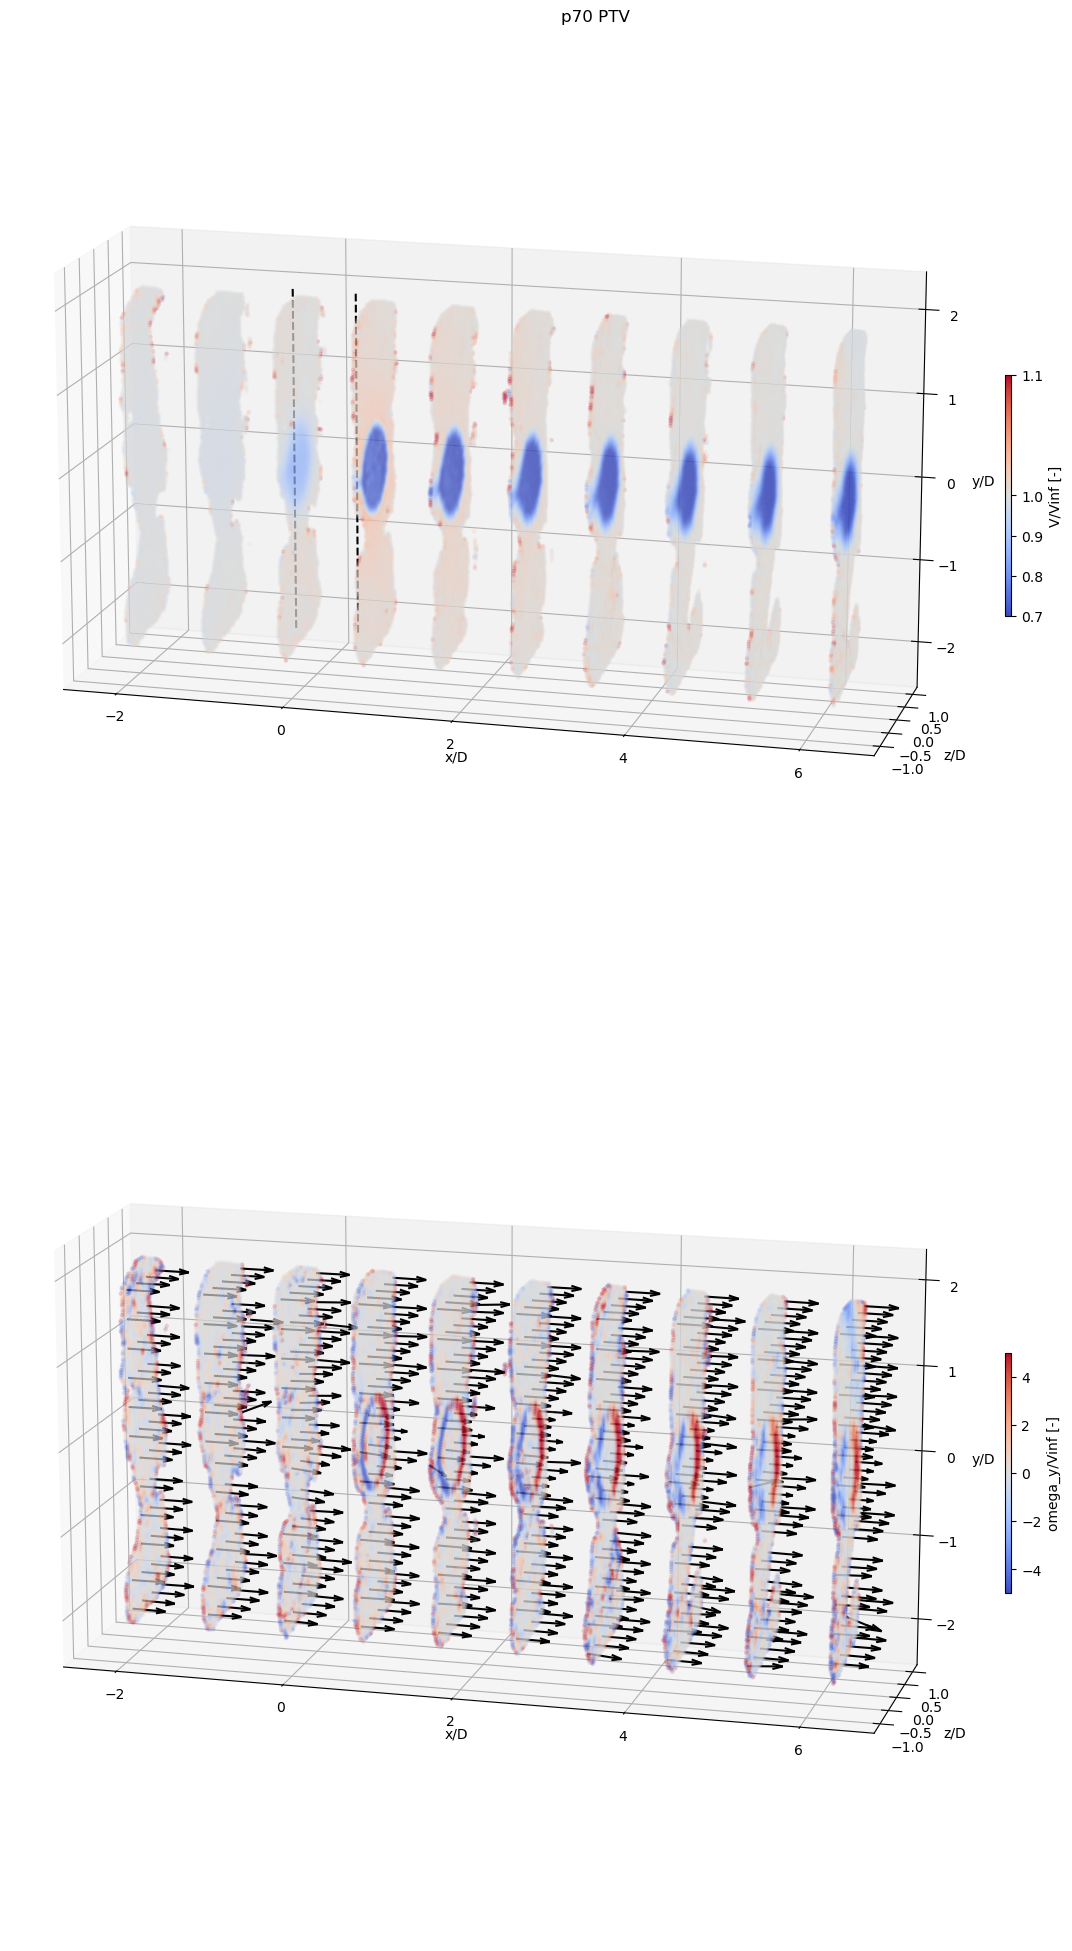

In [108]:
# ptv p70 plots

mask = ptv_p70_stitch.grid_valid_cell[::32,:,:] # circumvent the alpha bug in 3D scatter plots with nan values
mapping_plot = plt.figure(figsize=(12,20)).add_subplot(211, projection='3d').scatter(ptv_p70_stitch.grid_x[::32,:,:][mask], ptv_p70_stitch.grid_z[::32,:,:][mask], ptv_p70_stitch.grid_y[::32,:,:][mask], c=ptv_p70_stitch.grid_v_mag[::32,:,:][mask]/ptv_vinf, cmap='coolwarm', norm = mpl.colors.TwoSlopeNorm(vmin=0.7, vcenter=1.0, vmax=1.1), marker=".", alpha =0.1)
# plt.gca().quiver(ptv_p70_stitch.grid_x[::32,::12,::12], ptv_p70_stitch.grid_z[::32,::12,::12], ptv_p70_stitch.grid_y[::32,::12,::12], ptv_p70_stitch.grid_v_x[::32,::12,::12]/ptv_vinf, ptv_p70_stitch.grid_v_z[::32,::12,::12]/ptv_vinf, ptv_p70_stitch.grid_v_y[::32,::12,::12]/ptv_vinf, color='black', length=0.4)
plt.gca().set_aspect('equal')
plt.plot([-0.25,-0.25],[0,0],[ptv_p70_stitch.grid_y[::32,::12,::12].min(),ptv_p70_stitch.grid_y[::32,::12,::12].max()], color='black', linestyle='--')
plt.plot([0.5,0.5],[0,0],[ptv_p70_stitch.grid_y[::32,::12,::12].min(),ptv_p70_stitch.grid_y[::32,::12,::12].max()], color='black', linestyle='--')
# plt.plot([-0.5,6],[0,0],[0.5,0.5], color='black', linestyle='--')
# plt.plot([-0.5,6],[0,0],[-0.5,-0.5], color='black', linestyle='--')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.gca().set_zlabel("y/D")
plt.suptitle("p70 PTV")
plt.gca().view_init(elev=15, azim = -75)
plt.colorbar(mappable=mapping_plot, label="V/Vinf [-]", shrink=0.25, aspect=35).solids.set(alpha=1)

mapping_plot = plt.gcf().add_subplot(212, projection='3d').scatter(ptv_p70_stitch.grid_x[::32,:,:][mask], ptv_p70_stitch.grid_z[::32,:,:][mask], ptv_p70_stitch.grid_y[::32,:,:][mask], c=ptv_p70_stitch.grid_omega_y[::32,:,:][mask]/ptv_vinf, cmap='coolwarm', norm = mpl.colors.TwoSlopeNorm(vmin=-5, vcenter=0, vmax=5), marker=".", alpha =0.1)
plt.gca().quiver(ptv_p70_stitch.grid_x[::32,::12,::12], ptv_p70_stitch.grid_z[::32,::12,::12], ptv_p70_stitch.grid_y[::32,::12,::12], ptv_p70_stitch.grid_v_x[::32,::12,::12]/ptv_vinf, ptv_p70_stitch.grid_v_z[::32,::12,::12]/ptv_vinf, ptv_p70_stitch.grid_v_y[::32,::12,::12]/ptv_vinf, color='black', length=0.4)
plt.gca().set_aspect('equal')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.gca().set_zlabel("y/D")
plt.gca().view_init(elev=15, azim = -75)
plt.colorbar(mappable=mapping_plot, label="omega_y/Vinf [-]", shrink=0.25, aspect=35).solids.set(alpha=1)
plt.tight_layout()

# #testing 3d isosurface with plotly
# import plotly.graph_objects as go

# fig = go.Figure(data=go.Isosurface(x=ptv_p70_stitch.grid_x[99::10,:,:].flatten(),y=ptv_p70_stitch.grid_z[99::10,:,:].flatten(),z=ptv_p70_stitch.grid_y[99::10,:,:].flatten(),value=ptv_p70_stitch.grid_v_x[99::10,:,:].flatten()/ptv_vinf, isomin=0.95, isomax=0.95, surface_count=1, opacity=0.6))
# fig.show()



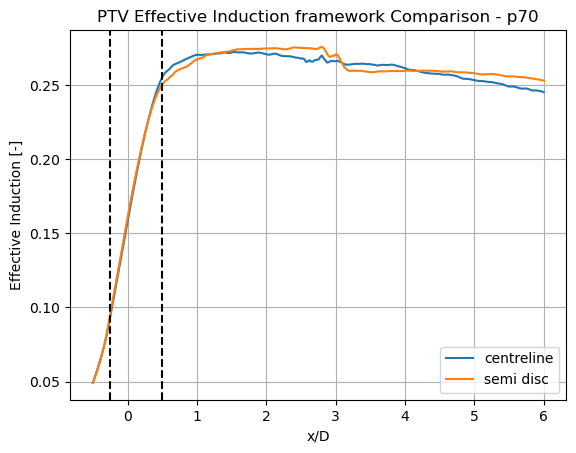

In [85]:
# p70 2d vs 3d eff induction comparison

plt.figure()
plt.title("PTV Effective Induction framework Comparison - p70")
plt.plot(np.linspace(-0.5,6,261), ptv_p70_stitch.get_eff_ind_intpr(v_inf=ptv_vinf, x_ustream_fin=-0.25, x_dstream_init=0.5, smooth=False, mode="2d")(np.linspace(-0.5,6,261)), label="centreline")
plt.plot(np.linspace(-0.5,6,261), ptv_p70_stitch.get_eff_ind_intpr(v_inf=ptv_vinf, x_ustream_fin=-0.25, x_dstream_init=0.5, smooth=False)(np.linspace(-0.5,6,261)), label="semi disc")
plt.axvline(x=-0.25, linestyle="--", color="black")
plt.axvline(x=0.5, linestyle="--", color="black")
plt.xlabel("x/D")
plt.ylabel("Effective Induction [-]")
plt.legend()
plt.grid()

p70 piv v_inf=3 at x/D=0:  0.13
p70 piv v_inf=2 at x/D=0:  0.152
p70 ptv v_inf=7.2 at x/D=0:  0.158
p70 piv v_inf=3 at x/D=1.9:  0.25
p70 piv v_inf=2 at x/D=1.9:  0.265
p70 ptv v_inf=7.2 at x/D=1.9:  0.272


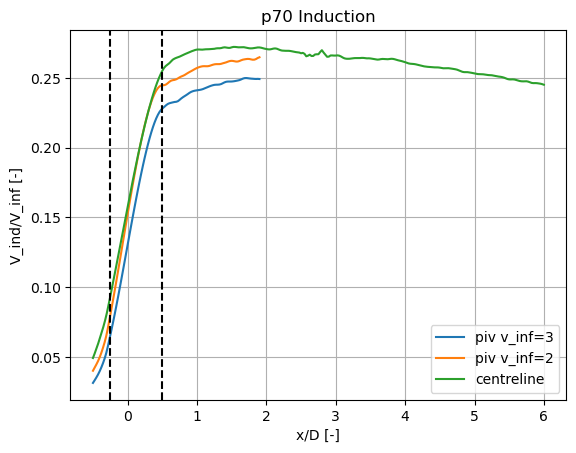

In [38]:
# P70 induction plots

plt.figure()
plt.plot(np.linspace(-0.5,1.9,101), piv_p70_case_06_phase_00_stitch.get_eff_ind_intpr(v_inf=piv_vinf_3, x_ustream_fin=-0.25, x_dstream_init=0.5)(np.linspace(-0.5,1.9,101)), label="piv v_inf=3")
plt.plot(np.linspace(-0.5,1.9,101), piv_p70_case_07_phase_00_stitch.get_eff_ind_intpr(v_inf=piv_vinf_2, x_ustream_fin=-0.25, x_dstream_init=0.5)(np.linspace(-0.5,1.9,101)), label="piv v_inf=2")
plt.plot(np.linspace(-0.5,6,261), ptv_p70_stitch.get_eff_ind_intpr(v_inf=ptv_vinf, x_ustream_fin=-0.25, x_dstream_init=0.5, smooth=False, mode="2d")(np.linspace(-0.5,6,261)), label="centreline")
plt.axvline(x=-0.25, linestyle="--", color="black")
plt.axvline(x=0.5, linestyle="--", color="black")
plt.xlabel("x/D [-]")
plt.ylabel("V_ind/V_inf [-]")
plt.title("p70 Induction")
plt.legend()
plt.grid()

# induction at x/D = 0

print("p70 piv v_inf=3 at x/D=0: ", piv_p70_case_06_phase_00_stitch.get_eff_ind_intpr(v_inf=piv_vinf_3, x_ustream_fin=-0.25, x_dstream_init=0.5)(0).round(3))
print("p70 piv v_inf=2 at x/D=0: ", piv_p70_case_07_phase_00_stitch.get_eff_ind_intpr(v_inf=piv_vinf_2, x_ustream_fin=-0.25, x_dstream_init=0.5)(0).round(3))
print("p70 ptv v_inf=7.2 at x/D=0: ", ptv_p70_stitch.get_eff_ind_intpr(v_inf=ptv_vinf, x_ustream_fin=-0.25, x_dstream_init=0.5, smooth=False, mode="2d")(0).round(3))

# Induction at far wake

print("p70 piv v_inf=3 at x/D=1.9: ", piv_p70_case_06_phase_00_stitch.get_eff_ind(1.9, piv_vinf_3).round(3))
print("p70 piv v_inf=2 at x/D=1.9: ", piv_p70_case_07_phase_00_stitch.get_eff_ind(1.9, piv_vinf_2).round(3))
print("p70 ptv v_inf=7.2 at x/D=1.9: ", ptv_p70_stitch.get_eff_ind_intpr(v_inf=ptv_vinf, x_ustream_fin=-0.25, x_dstream_init=0.5, smooth=False, mode="2d")(1.9).round(3)) 

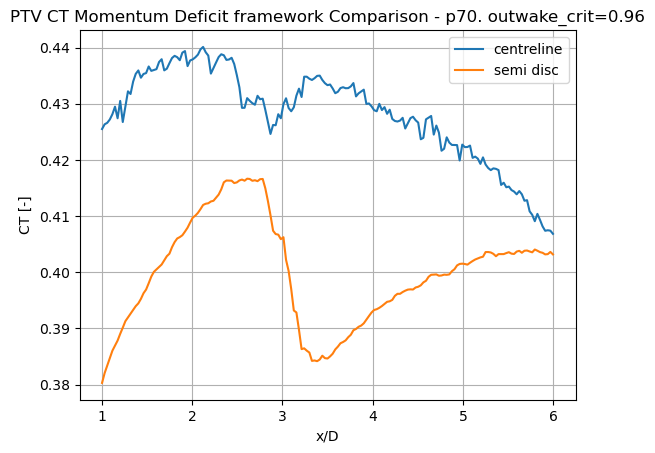

In [41]:
# 2d vs 3d ct momentum deficit plot

plt.figure()
plt.title("PTV CT Momentum Deficit framework Comparison - p70. outwake_crit=0.96")
plt.plot(*ptv_p70_stitch.get_CT_mom_deficit_2d(1, 6, ptv_vinf, ptv_rho_inf, outer_wake_crit=0.96), label="centreline")
plt.plot(*ptv_p70_stitch.get_CT_mom_deficit_stube_area(1, 6, ptv_vinf, ptv_rho_inf, outer_wake_crit=0.96), label="semi disc")
plt.xlabel("x/D")
plt.ylabel("CT [-]")
plt.legend()
plt.grid()

p70 piv v_inf=3 at x/D=1.8:  0.43
p70 piv v_inf=2 at x/D=1.8:  0.444
p70 ptv v_inf=7.2 at x/D=1.8:  0.442


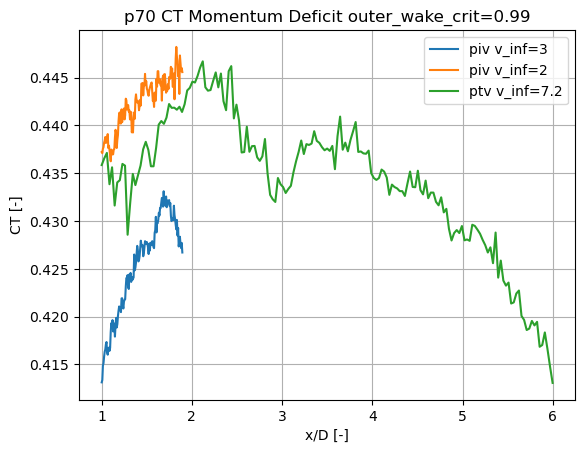

In [45]:
# p70 CT momentum deficit plots

plt.figure()
plt.plot(*piv_p70_case_06_phase_00_stitch.get_CT_mom_deficit(1, 1.9, piv_vinf_3, piv_rho_inf, outer_wake_crit=0.99), label="piv v_inf=3")
plt.plot(*piv_p70_case_07_phase_00_stitch.get_CT_mom_deficit(1, 1.9, piv_vinf_2, piv_rho_inf, outer_wake_crit=0.99), label="piv v_inf=2")
plt.plot(*ptv_p70_stitch.get_CT_mom_deficit_2d(1, 6, ptv_vinf, ptv_rho_inf, outer_wake_crit=0.99), label="ptv v_inf=7.2")
plt.xlabel("x/D [-]")
plt.ylabel("CT [-]")
plt.title("p70 CT Momentum Deficit outer_wake_crit=0.99")
plt.legend()
plt.grid()

print("p70 piv v_inf=3 at x/D=1.8: ", piv_p70_case_06_phase_00_stitch.get_CT_mom_deficit(1, 1.8, piv_vinf_3, piv_rho_inf, outer_wake_crit=0.99)[1][-1].round(3))
print("p70 piv v_inf=2 at x/D=1.8: ", piv_p70_case_07_phase_00_stitch.get_CT_mom_deficit(1, 1.8, piv_vinf_2, piv_rho_inf, outer_wake_crit=0.99)[1][-1].round(3))
print("p70 ptv v_inf=7.2 at x/D=1.8: ", ptv_p70_stitch.get_CT_mom_deficit_2d(1, 1.8, ptv_vinf, ptv_rho_inf, outer_wake_crit=0.99)[1][-1].round(3))


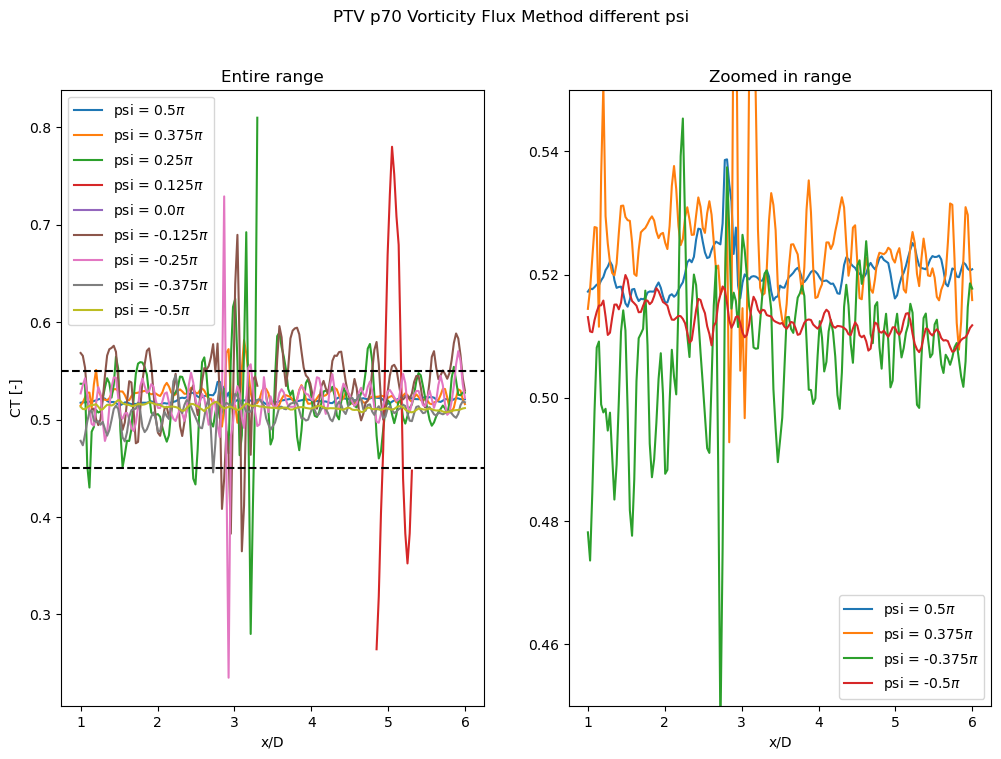

In [50]:
# PTv p70 vorticity flux different psi

ptv_p70_x_arr, ptv_p70_CT_arr = ptv_p70_stitch.get_CT_vort_flux(1, 6, ptv_vinf, cv_bound_crit=0.3, psi_qty=9)
psi_arr = np.linspace(np.pi/2, -np.pi/2, 9)

plt.figure(figsize=(12,8))
plt.suptitle("PTV p70 Vorticity Flux Method different psi")
plt.subplot(1,2,1)
plt.title("Entire range")
[plt.plot(ptv_p70_x_arr, np.absolute(CT_arr), label="psi = " + str(psi/np.pi) + r"$\pi$") for CT_arr, psi in zip(ptv_p70_CT_arr, psi_arr)]
plt.xlabel("x/D")
plt.ylabel("CT [-]")
plt.axhline(y=0.55, linestyle="--", color="black")
plt.axhline(y=0.45, linestyle="--", color="black")
plt.legend()
plt.subplot(1,2,2)
plt.title("Zoomed in range")
[plt.plot(ptv_p70_x_arr, np.absolute(CT_arr), label="psi = " + str(psi/np.pi) + r"$\pi$") for CT_arr, psi in zip(ptv_p70_CT_arr[np.array([0,1,-2,-1])], psi_arr[np.array([0,1,-2,-1])])]
plt.ylim(0.45,0.55)
plt.xlabel("x/D")
plt.legend()

0.025000000000000022
0.025000000000000022
piv delta x:  0.03334999999999977
ptv delta x:  0.028724999999999667
0.025000000000000022
0.025000000000000022
0.025000000000000022
0.025000000000000022
piv v_inf=3 vort flux CT:  0.475
piv v_inf=2 vort flux CT:  0.487
ptv v_inf=7.2 vort flux CT:  0.516


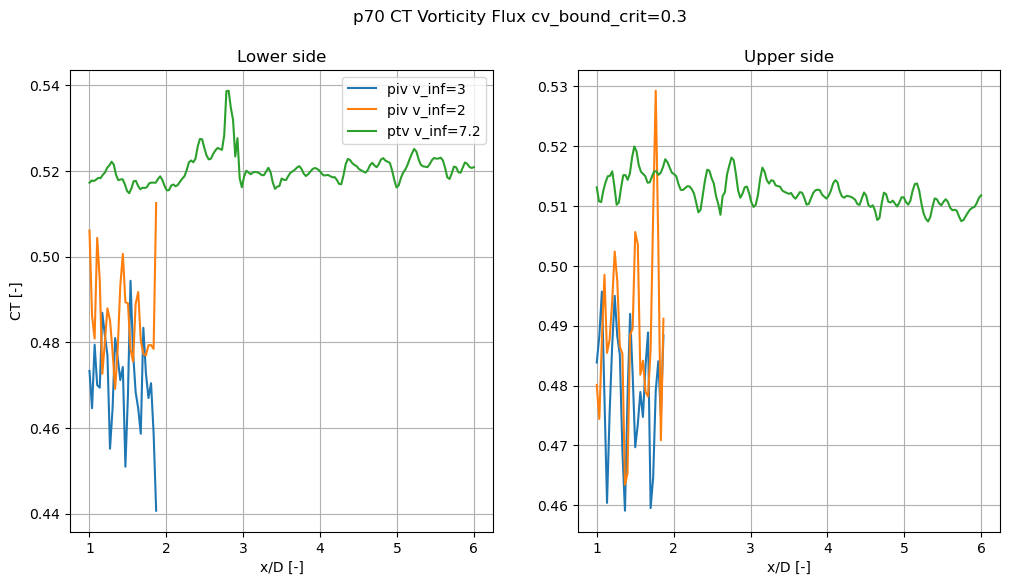

In [81]:
# p70 CT voticity flux plots

piv_p70_case_06_x_arr, piv_p70_case_06_CT_upper_arr, piv_p70_case_06_CT_lower_arr = piv_p70_case_06_phase_00_stitch.get_CT_vort_flux(1, 1.9, piv_vinf_3, cv_bound_crit=0.3)
piv_p70_case_07_x_arr, piv_p70_case_07_CT_upper_arr, piv_p70_case_07_CT_lower_arr = piv_p70_case_07_phase_00_stitch.get_CT_vort_flux(1, 1.9, piv_vinf_2, cv_bound_crit=0.3)
ptv_p70_x_arr, ptv_p70_CT_arr = ptv_p70_stitch.get_CT_vort_flux(1, 6, ptv_vinf, cv_bound_crit=0.3, psi_qty=2)

plt.figure(figsize=(12,6))
plt.suptitle("p70 CT Vorticity Flux cv_bound_crit=0.3")
plt.subplot(1,2,1)
plt.title("Lower side")
plt.plot(piv_p70_case_06_x_arr, np.absolute(piv_p70_case_06_CT_lower_arr), label="piv v_inf=3")
plt.plot(piv_p70_case_07_x_arr, np.absolute(piv_p70_case_07_CT_lower_arr), label="piv v_inf=2")
plt.plot(ptv_p70_x_arr, np.absolute(ptv_p70_CT_arr[0]), label="ptv v_inf=7.2")
plt.xlabel("x/D [-]")
plt.ylabel("CT [-]")
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.title("Upper side")
plt.plot(piv_p70_case_06_x_arr, np.absolute(piv_p70_case_06_CT_upper_arr), label="piv v_inf=3")
plt.plot(piv_p70_case_07_x_arr, np.absolute(piv_p70_case_07_CT_upper_arr), label="piv v_inf=2")
plt.plot(ptv_p70_x_arr, np.absolute(ptv_p70_CT_arr[1]), label="ptv v_inf=7.2")
plt.grid()
plt.xlabel("x/D [-]")

print("piv delta x: ", piv_p70_case_06_x_arr[1] - piv_p70_case_06_x_arr[0])
print("ptv delta x: ", ptv_p70_x_arr[1] - ptv_p70_x_arr[0])

piv_p70_case_06_vort_flux_CT = 0.5 * (np.absolute(piv_p70_case_06_phase_00_stitch.get_CT_vort_flux(1, 1.9, piv_vinf_3, cv_bound_crit=0.3)[1]) + np.absolute(piv_p70_case_06_phase_00_stitch.get_CT_vort_flux(1, 1.9, piv_vinf_3, cv_bound_crit=0.3)[2])).mean()
piv_p70_case_07_vort_flux_CT = 0.5 * (np.absolute(piv_p70_case_07_phase_00_stitch.get_CT_vort_flux(1, 1.9, piv_vinf_2, cv_bound_crit=0.3)[1]) + np.absolute(piv_p70_case_07_phase_00_stitch.get_CT_vort_flux(1, 1.9, piv_vinf_2, cv_bound_crit=0.3)[2])).mean()
ptv_p70_vort_flux_CT = 0.5 * (np.absolute(ptv_p70_stitch.get_CT_vort_flux(1, 1.9, ptv_vinf, cv_bound_crit=0.3, psi_qty=2)[1][0]) + np.absolute(ptv_p70_stitch.get_CT_vort_flux(1, 1.9, ptv_vinf, cv_bound_crit=0.3, psi_qty=2)[1][1])).mean()

print("piv v_inf=3 vort flux CT: ", piv_p70_case_06_vort_flux_CT.round(3))
print("piv v_inf=2 vort flux CT: ", piv_p70_case_07_vort_flux_CT.round(3))
print("ptv v_inf=7.2 vort flux CT: ", ptv_p70_vort_flux_CT.round(3))



In [55]:
# PTV p45 data

ptv_p45_vol0 = read_vol_ptv_data(dataDir + "/ptv/p45_static_upstream_rxx_filt11.dat")
p45_disc_xc = ptv_p45_vol0.deflt_grid_x[68,0,0]
p45_disc_yc = ptv_p45_vol0.deflt_grid_y[0,74,0]
p45_disc_zc = ptv_p45_vol0.deflt_grid_z[0,0,46]
ptv_p45_vol0.reorient_frame(p45_disc_xc, p45_disc_yc, p45_disc_zc)
ptv_p45_vol0.gen_intpr()

ptv_p45_vol1 = read_vol_ptv_data(dataDir + "/ptv/p45_static_midstream_rxx_filt11.dat")
ptv_p45_vol1.reorient_frame(p45_disc_xc, p45_disc_yc, p45_disc_zc)
ptv_p45_vol1.gen_intpr()

ptv_p45_vol2 = read_vol_ptv_data(dataDir + "/ptv/p45_static_downstream_rxx_filt11.dat")
ptv_p45_vol2.reorient_frame(p45_disc_xc, p45_disc_yc, p45_disc_zc)
ptv_p45_vol2.gen_intpr()

ptv_p45_stitch = stitched_vol_ptv_data()
ptv_p45_stitch.stitch_vols(ptv_p45_vol0, ptv_p45_vol1, ptv_p45_vol2)
ptv_p45_stitch.gen_intpr()

In [56]:
print(ptv_p45_vol0.deflt_grid_x[68,0,0])
print(ptv_p45_vol0.deflt_grid_y[0,74,0])
print(ptv_p45_vol0.deflt_grid_z[0,0,46])

-32.326
19.865
17.2353


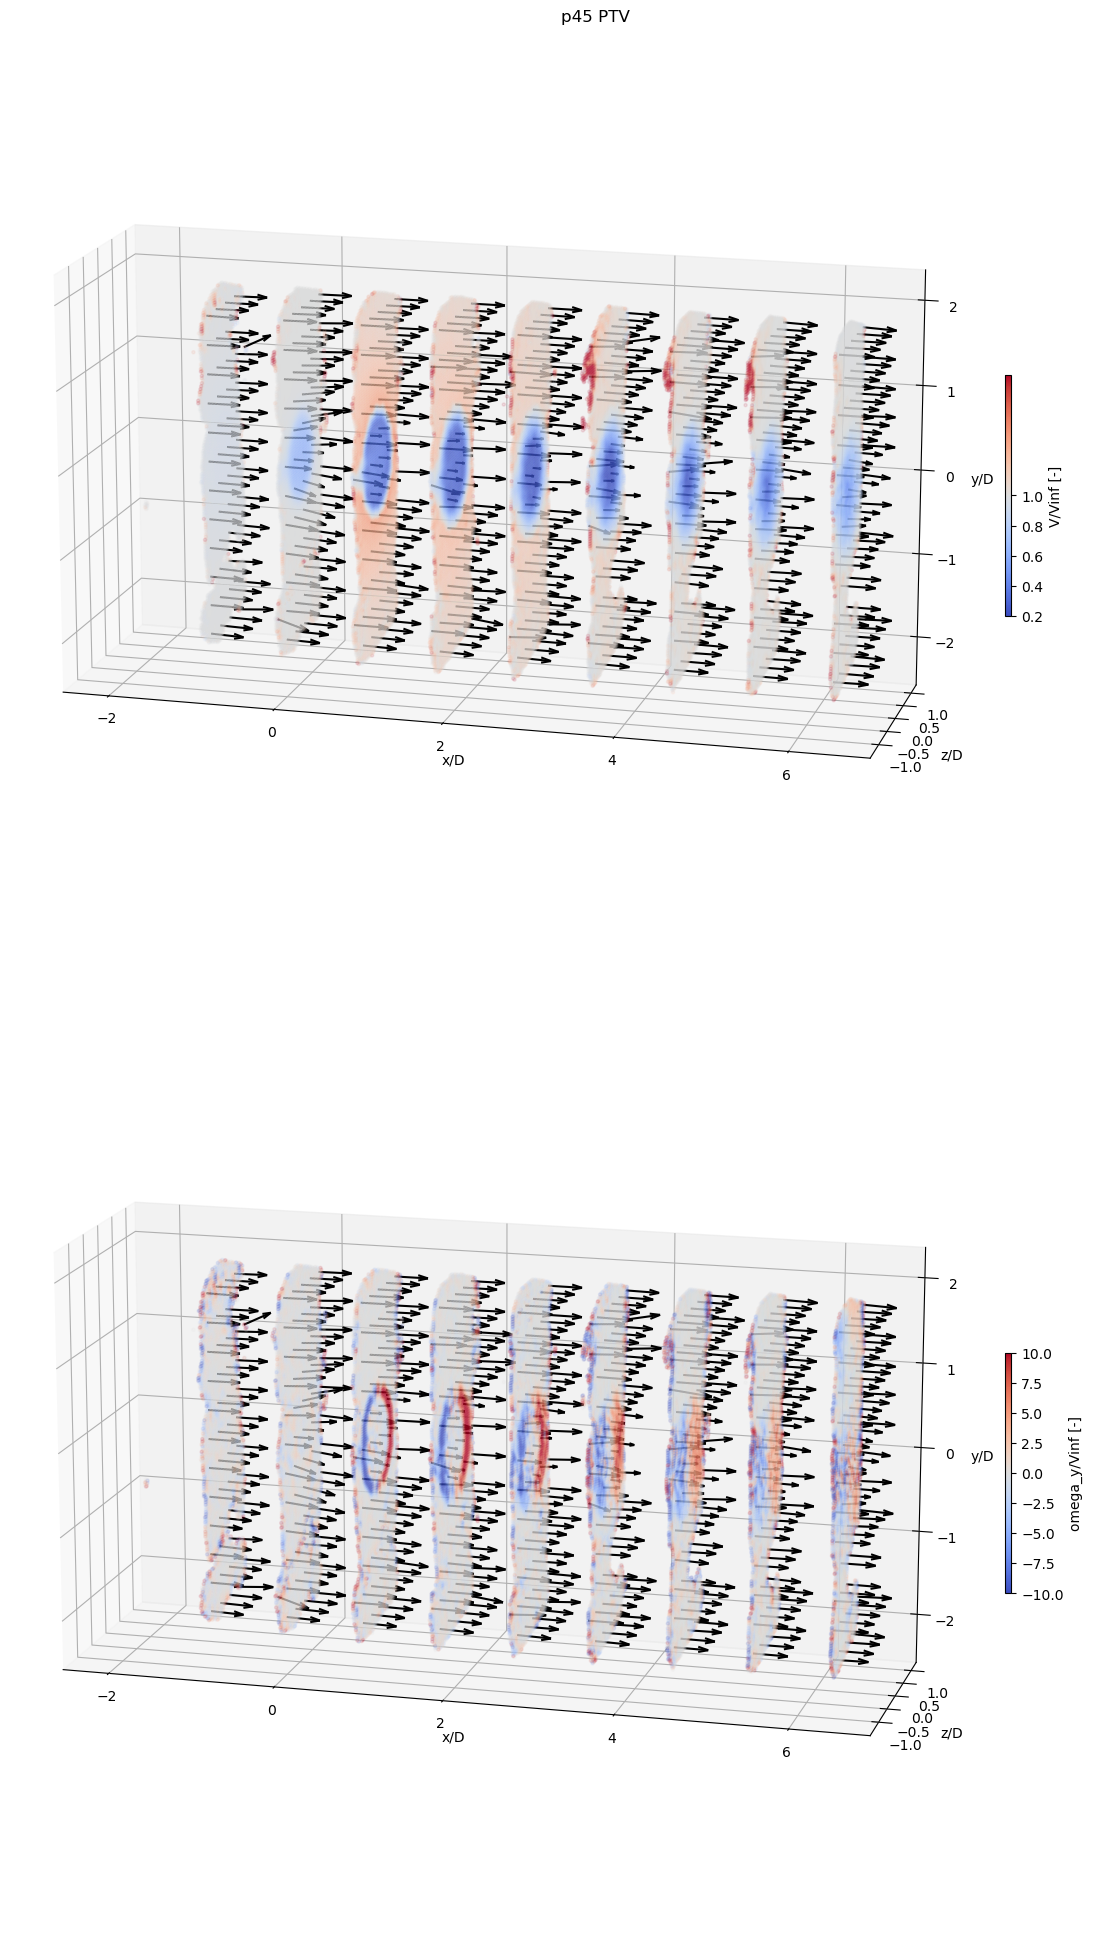

In [84]:
# ptv p45 plots

mask = ptv_p45_stitch.grid_valid_cell[::32,:,:] # circumvent the alpha bug in 3D scatter plots with nan values
mapping_plot = plt.figure(figsize=(12,20)).add_subplot(211, projection='3d').scatter(ptv_p45_stitch.grid_x[::32,:,:][mask], ptv_p45_stitch.grid_z[::32,:,:][mask], ptv_p45_stitch.grid_y[::32,:,:][mask], c=ptv_p45_stitch.grid_v_mag[::32,:,:][mask]/ptv_vinf, cmap='coolwarm', norm = mpl.colors.TwoSlopeNorm(vmin=0.2, vcenter=1.0, vmax=1.1), marker=".", alpha =0.1)
plt.gca().quiver(ptv_p45_stitch.grid_x[::32,::12,::12], ptv_p45_stitch.grid_z[::32,::12,::12], ptv_p45_stitch.grid_y[::32,::12,::12], ptv_p45_stitch.grid_v_x[::32,::12,::12]/ptv_vinf, ptv_p45_stitch.grid_v_z[::32,::12,::12]/ptv_vinf, ptv_p45_stitch.grid_v_y[::32,::12,::12]/ptv_vinf, color='black', length=0.4)
plt.gca().set_aspect('equal')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.gca().set_zlabel("y/D")
plt.suptitle("p45 PTV")
plt.gca().view_init(elev=15, azim = -75)
plt.colorbar(mappable=mapping_plot, label="V/Vinf [-]", shrink=0.25, aspect=35).solids.set(alpha=1)

mapping_plot = plt.gcf().add_subplot(212, projection='3d').scatter(ptv_p45_stitch.grid_x[::32,:,:][mask], ptv_p45_stitch.grid_z[::32,:,:][mask], ptv_p45_stitch.grid_y[::32,:,:][mask], c=ptv_p45_stitch.grid_omega_y[::32,:,:][mask]/ptv_vinf, cmap='coolwarm', norm = mpl.colors.TwoSlopeNorm(vmin=-10, vcenter=0, vmax=10), marker=".", alpha =0.1)
plt.gca().quiver(ptv_p45_stitch.grid_x[::32,::12,::12], ptv_p45_stitch.grid_z[::32,::12,::12], ptv_p45_stitch.grid_y[::32,::12,::12], ptv_p45_stitch.grid_v_x[::32,::12,::12]/ptv_vinf, ptv_p45_stitch.grid_v_z[::32,::12,::12]/ptv_vinf, ptv_p45_stitch.grid_v_y[::32,::12,::12]/ptv_vinf, color='black', length=0.4)
plt.gca().set_aspect('equal')
plt.xlabel("x/D")
plt.ylabel("z/D")
plt.gca().set_zlabel("y/D")
plt.gca().view_init(elev=15, azim = -75)
plt.colorbar(mappable=mapping_plot, label="omega_y/Vinf [-]", shrink=0.25, aspect=35).solids.set(alpha=1)
plt.tight_layout()

p45 piv v_inf=3 at x/D=0:  0.335
p45 piv v_inf=2 at x/D=0:  0.345
p45 ptv v_inf=7.2 at x/D=0:  0.374
p45 piv v_inf=3 at x/D=1.75:  0.664
p45 piv v_inf=2 at x/D=1.75:  0.675
p45 ptv v_inf=7.2 at x/D=1.75:  0.694


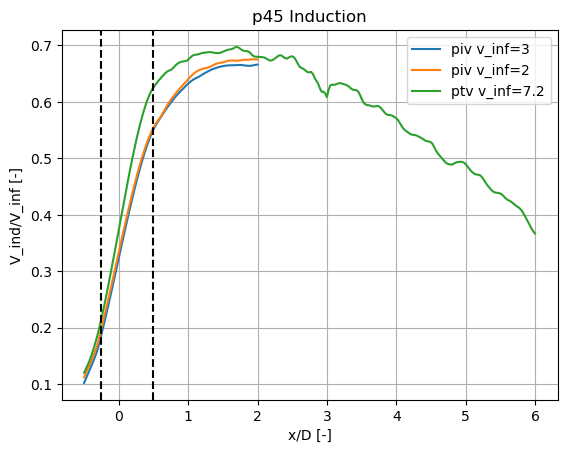

In [61]:
# p45 effective ind plots

plt.figure()
plt.plot(np.linspace(-0.5,2,101), piv_p45_case_06_phase_00_stitch.get_eff_ind_intpr(v_inf=piv_vinf_3, x_ustream_fin=-0.25, x_dstream_init=0.5)(np.linspace(-0.5,1.9,101)), label="piv v_inf=3")
plt.plot(np.linspace(-0.5,2,101), piv_p45_case_07_phase_00_stitch.get_eff_ind_intpr(v_inf=piv_vinf_2, x_ustream_fin=-0.25, x_dstream_init=0.5)(np.linspace(-0.5,1.9,101)), label="piv v_inf=2")
plt.plot(np.linspace(-0.5,6,261), ptv_p45_stitch.get_eff_ind_intpr(v_inf=ptv_vinf, x_ustream_fin=-0.25, x_dstream_init=0.5, smooth=False, mode="2d")(np.linspace(-0.5,6,261)), label="ptv v_inf=7.2")
plt.axvline(x=-0.25, linestyle="--", color="black")
plt.axvline(x=0.5, linestyle="--", color="black")
plt.xlabel("x/D [-]")
plt.ylabel("V_ind/V_inf [-]")
plt.title("p45 Induction")
plt.legend()
plt.grid()

print("p45 piv v_inf=3 at x/D=0: ", piv_p45_case_06_phase_00_stitch.get_eff_ind_intpr(v_inf=piv_vinf_3, x_ustream_fin=-0.25, x_dstream_init=0.5)(0).round(3))
print("p45 piv v_inf=2 at x/D=0: ", piv_p45_case_07_phase_00_stitch.get_eff_ind_intpr(v_inf=piv_vinf_2, x_ustream_fin=-0.25, x_dstream_init=0.5)(0).round(3))
print("p45 ptv v_inf=7.2 at x/D=0: ", ptv_p45_stitch.get_eff_ind_intpr(v_inf=ptv_vinf, x_ustream_fin=-0.25, x_dstream_init=0.5, smooth=False, mode="2d")(0).round(3))

print("p45 piv v_inf=3 at x/D=1.75: ", piv_p45_case_06_phase_00_stitch.get_eff_ind(1.75, piv_vinf_3).round(3))
print("p45 piv v_inf=2 at x/D=1.75: ", piv_p45_case_07_phase_00_stitch.get_eff_ind(1.75, piv_vinf_2).round(3))
print("p45 ptv v_inf=7.2 at x/D=1.75: ", ptv_p45_stitch.get_eff_ind_intpr(v_inf=ptv_vinf, x_ustream_fin=-0.25, x_dstream_init=0.5, smooth=False, mode="2d")(1.75).round(3))


p45 piv v_inf=3 at x/D=1.75:  0.708
p45 piv v_inf=2 at x/D=1.75:  0.698
p45 ptv v_inf=7.2 at x/D=5.5:  0.74


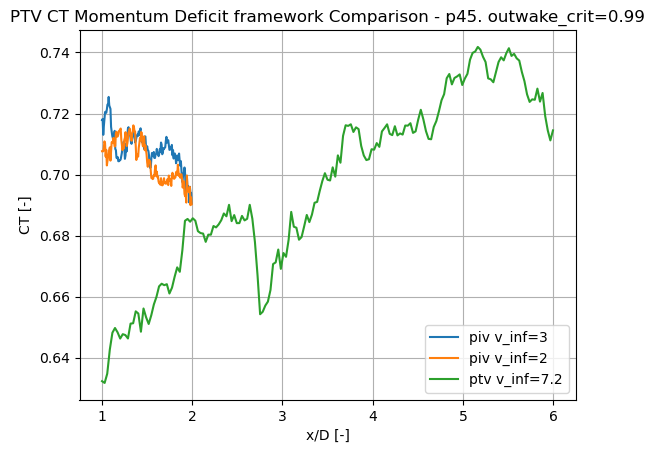

In [66]:
# p45 CT momentum deficit plots

plt.figure()
plt.title("PTV CT Momentum Deficit framework Comparison - p45. outwake_crit=0.99")
plt.plot(*piv_p45_case_06_phase_00_stitch.get_CT_mom_deficit(1, 2, piv_vinf_3, piv_rho_inf, outer_wake_crit=0.99), label="piv v_inf=3")
plt.plot(*piv_p45_case_07_phase_00_stitch.get_CT_mom_deficit(1, 2, piv_vinf_2, piv_rho_inf, outer_wake_crit=0.99), label="piv v_inf=2")
plt.plot(*ptv_p45_stitch.get_CT_mom_deficit_2d(1, 6, ptv_vinf, ptv_rho_inf, outer_wake_crit=0.99), label="ptv v_inf=7.2")
plt.xlabel("x/D [-]")
plt.ylabel("CT [-]")
plt.legend()
plt.grid()

print(f"p45 piv v_inf=3 at x/D=1.75: ", piv_p45_case_06_phase_00_stitch.get_CT_mom_deficit(1, 1.75, piv_vinf_3, piv_rho_inf, outer_wake_crit=0.99)[1][-1].round(3))
print(f"p45 piv v_inf=2 at x/D=1.75: ", piv_p45_case_07_phase_00_stitch.get_CT_mom_deficit(1, 1.75, piv_vinf_2, piv_rho_inf, outer_wake_crit=0.99)[1][-1].round(3))
print(f"p45 ptv v_inf=7.2 at x/D=5.5: ", ptv_p45_stitch.get_CT_mom_deficit_2d(1, 5.5, ptv_vinf, ptv_rho_inf, outer_wake_crit=0.99)[1][-1].round(3))


0.025000000000000022
0.025000000000000022
0.025000000000000022
0.025000000000000022
p45 piv v_inf=3 vort flux CT:  0.988
0.025000000000000022
0.025000000000000022
p45 piv v_inf=2 vort flux CT:  0.99
p45 ptv v_inf=7.2 vort flux CT:  0.9475


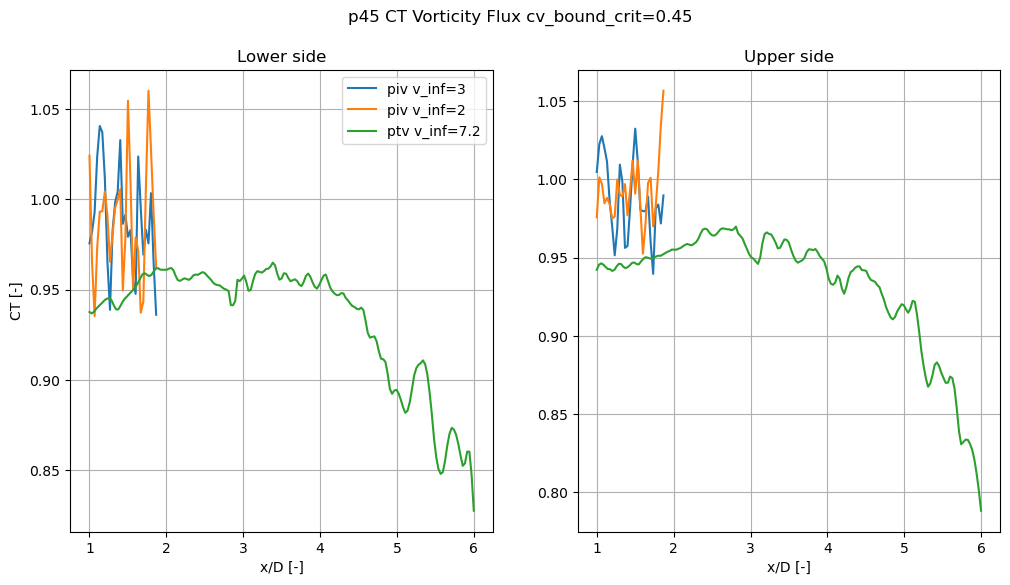

In [80]:
#p45 CT vorticity flux plots

piv_p45_case_06_x_arr, piv_p45_case_06_CT_upper_arr, piv_p45_case_06_CT_lower_arr = piv_p45_case_06_phase_00_stitch.get_CT_vort_flux(1, 1.9, piv_vinf_3, cv_bound_crit=0.45)
piv_p45_case_07_x_arr, piv_p45_case_07_CT_upper_arr, piv_p45_case_07_CT_lower_arr = piv_p45_case_07_phase_00_stitch.get_CT_vort_flux(1, 1.9, piv_vinf_2, cv_bound_crit=0.45)
ptv_p45_x_arr, ptv_p45_CT_arr = ptv_p45_stitch.get_CT_vort_flux(1, 6, ptv_vinf, cv_bound_crit=0.45, psi_qty=2)

plt.figure(figsize=(12,6))
plt.suptitle("p45 CT Vorticity Flux cv_bound_crit=0.45")
plt.subplot(1,2,1)
plt.title("Lower side")
plt.plot(piv_p45_case_06_x_arr, np.absolute(piv_p45_case_06_CT_lower_arr), label="piv v_inf=3")
plt.plot(piv_p45_case_07_x_arr, np.absolute(piv_p45_case_07_CT_lower_arr), label="piv v_inf=2")
plt.plot(ptv_p45_x_arr, np.absolute(ptv_p45_CT_arr[0]), label="ptv v_inf=7.2", color="tab:green")
plt.xlabel("x/D [-]")
plt.ylabel("CT [-]")
plt.grid()
plt.legend()
plt.subplot(1,2,2)
plt.title("Upper side")
plt.plot(piv_p45_case_06_x_arr, np.absolute(piv_p45_case_06_CT_upper_arr), label="piv v_inf=3")
plt.plot(piv_p45_case_07_x_arr, np.absolute(piv_p45_case_07_CT_upper_arr), label="piv v_inf=2")
plt.plot(ptv_p45_x_arr, np.absolute(ptv_p45_CT_arr[1]), label="ptv v_inf=7.2", color="tab:green")
plt.grid()
plt.xlabel("x/D [-]")

print("p45 piv v_inf=3 vort flux CT: ", 0.5 * (np.absolute(piv_p45_case_06_phase_00_stitch.get_CT_vort_flux(1, 1.9, piv_vinf_3, cv_bound_crit=0.45)[1]) + np.absolute(piv_p45_case_06_phase_00_stitch.get_CT_vort_flux(1, 1.9, piv_vinf_3, cv_bound_crit=0.45)[2])).mean().round(3))
print("p45 piv v_inf=2 vort flux CT: ", 0.5 * (np.absolute(piv_p45_case_07_phase_00_stitch.get_CT_vort_flux(1, 1.9, piv_vinf_2, cv_bound_crit=0.45)[1]) + np.absolute(piv_p45_case_07_phase_00_stitch.get_CT_vort_flux(1, 1.9, piv_vinf_2, cv_bound_crit=0.45)[2])).mean().round(3))
print("p45 ptv v_inf=7.2 vort flux CT: ", 0.5 * (np.absolute(ptv_p45_stitch.get_CT_vort_flux(1, 1.9, ptv_vinf, cv_bound_crit=0.45, psi_qty=2)[1][0]) + np.absolute(ptv_p45_stitch.get_CT_vort_flux(1, 1.9, ptv_vinf, cv_bound_crit=0.45, psi_qty=2)[1][1])).mean().round(3))